---
# **Bibliotecas**

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
import math
import random
import joblib
import pickle 

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# Keras
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras import models, layers, callbacks
    from tensorflow.keras import backend as K
except:
    !pip install tensorflow
    from tensorflow.keras.models import Sequential
    from tensorflow.keras import models, layers, callbacks
    from tensorflow.keras import backend as K

# OPENAI
try:
    import gym
except:
    !pip install gym
    import gym

# CoppeliaSim
try:
    import sim
except:
    !pip install sim
    import sim

# Ambiente Drone - CoppeliaSim
import CoppeliaEnv

try:
    import pymap3d as pm
except:
    !pip install pymap3d
    import pymap3d as pm

import warnings
warnings.filterwarnings("ignore")

import sys
import os
file_path = 'EKF/'
sys.path.insert(0, file_path)

import relacaoAngQuat as AngQuat # Relação entre Ângulos e Quatérnios
import func_EKF as EKF # Funções do EKF - Abordagem 01

sys.path.insert(0, 'NNBO/')


2025-03-06 12:57:35.181861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 12:57:35.188885: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 12:57:35.202019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741276655.222816   19014 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741276655.228173   19014 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 12:57:35.251108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

---
# **Implementação EKF-CoppeliaSim**

In [2]:
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if(clientID!=-1):
    print ('Connected to remote API server')
    ''' Inicialização do Drone '''
    robotname = 'Quadcopter'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, target = sim.simxGetObjectHandle(clientID, '/target', sim.simx_opmode_oneshot_wait)
    returnCode, refMov = sim.simxGetObjectHandle(clientID, '/reference', sim.simx_opmode_oneshot_wait)
    returnCode, signalAcc = sim.simxGetStringSignal(clientID, "dataAcc", sim.simx_opmode_oneshot_wait)
    returnCode, signalGyr = sim.simxGetStringSignal(clientID, "dataGyr", sim.simx_opmode_oneshot_wait)
    returnCode, signalMag = sim.simxGetStringSignal(clientID, "dataMag", sim.simx_opmode_oneshot_wait)
    returnCode, signalGPS = sim.simxGetStringSignal(clientID, "dataGPS", sim.simx_opmode_oneshot_wait)
    
    ''' Reset Posição e Orientação do Robô (Origem) '''
    returnCode = sim.simxSetObjectPosition(clientID, robotHandle, -1, [0, 0, 0.05], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, robotHandle, -1, [0, 0, np.pi], sim.simx_opmode_oneshot_wait)

''' Environment Coppelia '''
env = gym.make("CoppeliaEnv/Drone-v0", modeCoppelia=0, ctrlAng=False, ctrlPos=False,
              render_mode="human", size=1, epsilon=2)

''' Reset Environment '''
env.reset()
returnCode = sim.simxSynchronousTrigger(clientID)


Connected to remote API server


---
# **Variáveis e Constantes**

## ***Criação de Variáveis***

In [3]:
path_Folder = "Log Coppelia"
list_folders = os.listdir(path_Folder)
file_number = int(len(list_folders)/2)

save_File = "Controlador"
param_a = np.random.randint(-5, high=5)
param_b = np.random.randint(-5, high=5)
param_c = np.random.randint(-5, high=5)
param_z = np.random.randint(0, high=5)

param_a = 1
param_b = -2
param_c = 2
param_z = 2

save_File = "GPS Sequencial (" +str(param_a) +str(param_b) +str(param_c) +str(param_z) +")"

''' Ruídos '''
# Gyro = deg/s -> rad/s
gyro_mean = (np.pi/180) *np.array([.022809, -.092310, .052689]) 
gyro_std  = (np.pi/180) *np.array([.113324, .087879, .146402])
# Acc = g -> m/s²
acc_mean  = 9.81 *np.array([.012902, .022613, -0.008957])
acc_std   = 9.81 *np.array([.007402, .007968, .007472])
# Mag = ?
mag_mean  = np.array([-0.743596, 0.027920, -0.668504])
mag_std   = np.array([.007188, .008480, .008114])
# Pos = m
GPS_Corr = 0
chance_Pos1 = 0
pos1_mean  = np.random.rand(3)-.5
pos_std1   = 1*np.random.rand(3)
chance_Pos2 = 0
pos2_mean  = np.random.rand(3)-.5
pos_std2   = 5*np.random.rand(3)
chance_Pos3 = 0
pos3_mean  = np.random.rand(3)-.5
pos_std3   = 10*np.random.rand(3)
# Ang = rad
ang_mean  = 0*np.array([.24942687, .01284938, -.02230899])
ang_std   = 0*np.array([.01423651, .00069928, .00069682])

set_Ctrl = False

''' Variáveis de Tempo '''
dt = 0
tempo = 0
tempoAnt = 0
nCalib = 20
Stop = 1  # Tempo para Finalização [minutos]

''' Correções de Inicialização '''
Correcao = 0
Correcao_Sens_GPS = 0
Correcao_Sens_Pos = 0
Correcao_Sens_Att = 0
Correcao_Sens_Mag = 0

''' Aplicação Simutânea do EKF '''
tCor_Geral = 1e-3           # Tempo de Correção [s]
tCor_Sens_GPS = np.inf      # Tempo de Correção com Posição por Sensor [s]
tCor_Sens_Pos = np.inf      # Tempo de Correção com Posição por Sensor [s]
tCor_Sens_Att = np.inf      # Tempo de Correção com Atitude por Sensor [s]
tCor_Sens_Mag = .1      # Tempo de Correção com Magnetômetro [s]

''' Variáveis de Estado '''
pos0 = np.array([[0],[0],[0]])
pos = np.array([[0],[0],[0]])       # Posições X, Y e Z da IMU
vel = np.array([[0],[0],[0]])       # Velocidades X, Y e Z da IMU
ang = np.array([[0],[0],[0]])       # Ângulos Yaw, Pitch, Roll
q = np.array([[1],[0],[0],[0]])     # Quartérnios W, X, Y e Z

''' Variáveis de Sensores '''
acc = np.array([[0],[0],[0]])       # Medições do Acelerômetro
gyro = np.array([[0],[0],[0]])      # Medições do Giroscópio
mag = np.array([[0],[0],[0]])       # Medições do Magnetômetro
gps = np.array([[0],[0],[0]])       # Medições do GPS
gForce = -9.81
grav = np.array([[0],[0],[gForce]]) # Vetor de Gravidade

''' Bias '''
bias_Pos = np.array([0,0,0]).reshape([3,1])
bias_Ang = np.array([0,0,0]).reshape([3,1])
q = AngQuat.Euler2Quaternion(ang)
Rq = AngQuat.MatrixQuaternion(q)
bias_Gyr = np.array([0,0,0]).reshape([3,1])     # Giroscópio
accCalib = np.array([0,0,0]).reshape([3,1])     
bias_Acc = accCalib #+(Rq.T @ grav)              # Acelerômetro

''' Ruídos '''
ruido_Pos = np.array([0,0,0])                   # Posição
ruido_Vel = np.array(ruido_Pos)                 # Velocidade
ruido_Ang = np.array([0,0,0])                   # Ângulo
ruido_Gyr = np.array([0,0,0])                   # Giroscópio
ruido_accCalib = (gForce**2) *np.array([0,0,0])
ruido_Acc = Rq.T @ ruido_accCalib               # Acelerômetro
ruido_Mag = np.array([0,0,0])                   # Magnetômetro

''' Ruído do Bias '''
ruido_BiasGyr = 1e-5*np.array([1,1,1])               # Giroscópio
ruido_BiasAccCalib = 1e-5*np.array([1,1,1])
ruido_BiasAcc = 1e-3*np.array([1,1,1])       # Acelerômetro
ruido_BiasMag = 1e-5*np.array([1,1,1])               # Magnetômetro

''' EKF '''
x = np.vstack([pos, vel, q, bias_Gyr, bias_Acc])
xtilde = np.vstack([pos, vel, ang, bias_Gyr, bias_Acc])
ruidos = np.hstack([ruido_Gyr, ruido_BiasGyr, 
                    ruido_Acc, ruido_BiasAcc]).reshape([12,1])

zSens = np.zeros(6)

''' Matrizes de Covariância '''
P = xtilde*xtilde.T
Q = np.diag(np.hstack([ruido_Gyr, ruido_BiasGyr, ruido_Acc, ruido_BiasAcc]))
Qd = np.eye(15)
R = np.diag(np.hstack([ruido_Pos, ruido_Vel, ruido_Ang]))

''' Matrizes do Filtro de Kalman - Abordagem 01 '''
Eye = np.eye(3)
Eye15 = np.eye(15)
Zero = np.zeros([3,3])

''' Mirzaei & Roumeliotis, 2008 '''
Rq = AngQuat.MatrixQuaternion(x[6:10])
Sacc = EKF.Skew(acc-x[13:16])
RqSacc = Rq*Sacc

Sgyro = EKF.Skew(gyro-x[10:13])

F = np.vstack([np.hstack([Zero,  Eye, Zero, Zero, Zero]),
               np.hstack([Zero, Zero, -RqSacc, Zero, -Rq]),
               np.hstack([Zero, Zero, -Sgyro, Zero, -Eye]),
               np.hstack([Zero, Zero, Zero, Zero, Zero]),
               np.hstack([Zero, Zero, Zero, Zero, Zero])])

G = np.vstack([np.hstack([Zero, Zero, Zero, Zero]),
               np.hstack([Zero, Zero, -Rq, Zero]),
               np.hstack([-Eye, Zero, Zero, Zero]),
               np.hstack([Zero, Eye,  Zero, Zero]),
               np.hstack([Zero, Zero, Zero,  Eye])])

''' Matriz de Observação '''
H = np.vstack([np.hstack([ Eye, Zero, Zero, Zero, Zero]),
               np.hstack([Zero, Eye, Zero, Zero, Zero]),
               np.hstack([Zero, Zero,  Eye, Zero, Zero])])

''' Logs '''
histTempo = []      # Tempo
histRealAcc = []        # Sensor Acelerômetro
histAcc = []        # Sensor Acelerômetro
histRealGyro = []       # Sensor Giroscópio
histGyro = []       # Sensor Giroscópio
histRealMag = []        # Sensor Magnetômetro
histMag = []        # Sensor Magnetômetro
histZ = []          # Sensor
histRefAng = []     # Referência Ângulos
histRealAng = []    # Real Ângulos
histAng = []        # Ângulos
histRefQuat = []    # Referência Quatérnios
histRealQuat = []   # Real Quatérnios
histQuat = []       # Quatérnios
histRefPos = []     # Referência Posição
histRealPos = []    # Real Posição
histPos = []        # Posição
histRefVel = []     # Referência Velocidade
histRealVel = []    # Real Velocidade
histVel = []        # Velocidade
histBias = []       # Bias
histGrav = []       # Gravidade
histP = []          # Matriz P
histNNBO = []       # NNBO
histGPS = []        # GPS
histCorrPos = []    # Correções de Posição

## ***Configuração NNBO***

In [4]:
''' NNBO '''
path_NNBO = "NNBO/0628_AbolDeepIO_I27O18_32_10_9"
flag_PropNNBO = False
flag_LimiNNBO = False

n_neuronios = 32
size_window = 10
stride = 1
size_kernel = 5
n_hidden_layer = 10
overlap = size_window-1
set_shuffle = False
nFeatures = 9
nTarget = 6
input_NNBO = np.zeros([1, size_window, nFeatures])

'''IONet   IONet_New   AbolDeepIO   AbolDeepIO_New   AbolDeepIO_Slow   OxIOD'''
configRede = "AbolDeepIO_New"

'''LSTM   GRU   MLP'''
tipoRede = "LSTM"

dpos_NNBO = 0
dang_NNBO = 0

## ***Configuração Rede Neural***

In [5]:
NN_input = layers.Input(shape=(size_window, nFeatures))

if(configRede == "IONet_New"):
    NN_acc = layers.Lambda(lambda x: x[:,:,0:3])(NN_input)
    NN_gyr = layers.Lambda(lambda x: x[:,:,3:6])(NN_input)
    NN_mag = layers.Lambda(lambda x: x[:,:,6:9])(NN_input)
    
    convAcc = layers.Conv1D(filters=n_neuronios, strides=stride, kernel_size=size_window//2)(NN_acc)
    convAcc = layers.Conv1D(filters=n_neuronios, strides=stride, kernel_size=size_window//4)(convAcc)
    convAcc = layers.MaxPool1D(pool_size=2)(convAcc)
    
    convGyr = layers.Conv1D(filters=n_neuronios, strides=stride, kernel_size=size_window//2)(NN_gyr)
    convGyr = layers.Conv1D(filters=n_neuronios, strides=stride, kernel_size=size_window//4)(convGyr)
    convGyr = layers.MaxPool1D(pool_size=2)(convGyr)
    
    convMag = layers.Conv1D(filters=n_neuronios, strides=stride, kernel_size=size_window//2)(NN_mag)
    convMag = layers.Conv1D(filters=n_neuronios, strides=stride, kernel_size=size_window//4)(convMag)
    convMag = layers.MaxPool1D(pool_size=2)(convMag)
    
    IMU = layers.concatenate(inputs=[convAcc, convGyr, convMag])
    
    NN = layers.Bidirectional(layers.LSTM(n_neuronios, return_sequences=True))(IMU)
    NN = layers.Dropout(rate=0.25)(NN)
    NN = layers.Bidirectional(layers.LSTM(2*n_neuronios))(NN)
    NN = layers.Dropout(rate=0.25)(NN)
    
elif(configRede == "AbolDeepIO_New"):
    NN_acc = layers.Lambda(lambda x: x[:,:,0:3])(NN_input)
    NN_gyr = layers.Lambda(lambda x: x[:,:,3:6])(NN_input)
    NN_mag = layers.Lambda(lambda x: x[:,:,6:9])(NN_input)

    NN1 = layers.LSTM(n_neuronios, return_sequences=True)(NN_acc)
    NN1 = layers.Dropout(rate=0.25)(NN1)
    NN2 = layers.LSTM(n_neuronios, return_sequences=True)(NN_gyr)
    NN2 = layers.Dropout(rate=0.25)(NN2)
    NN3 = layers.LSTM(n_neuronios, return_sequences=True)(NN_mag)
    NN3 = layers.Dropout(rate=0.25)(NN3)

    NN1 = layers.LSTM(n_neuronios+n_neuronios//2, return_sequences=True)(NN1)
    NN1 = layers.Dropout(rate=0.25)(NN1)
    NN2 = layers.LSTM(n_neuronios+n_neuronios//2, return_sequences=True)(NN2)
    NN2 = layers.Dropout(rate=0.25)(NN2)
    NN3 = layers.LSTM(n_neuronios+n_neuronios//2, return_sequences=True)(NN3)
    NN3 = layers.Dropout(rate=0.25)(NN3)

    NN1 = layers.LSTM(n_neuronios, return_sequences=True)(NN1)
    NN1 = layers.Dropout(rate=0.25)(NN1)
    NN2 = layers.LSTM(n_neuronios, return_sequences=True)(NN2)
    NN2 = layers.Dropout(rate=0.25)(NN2)
    NN3 = layers.LSTM(n_neuronios, return_sequences=True)(NN3)
    NN3 = layers.Dropout(rate=0.25)(NN3)

    IMU = layers.concatenate(inputs=[NN1, NN2, NN3])

    NN = layers.LSTM(2*n_neuronios, return_sequences=True)(IMU)
    NN = layers.Dropout(rate=0.25)(NN)

    NN = layers.LSTM(n_neuronios, return_sequences=True)(NN)
    NN = layers.Dropout(rate=0.25)(NN)

    NN = layers.LSTM(n_neuronios//2)(NN)
    NN = layers.Dropout(rate=0.25)(NN)
    
elif(configRede == "OxIOD"):
    NN = layers.LSTM(n_neuronios)(NN_input)
    NN = layers.Dropout(rate=0.25)(NN)
    NN = layers.Dense(units=2*n_neuronios)(NN)
    
NN_output = layers.Dense(units=nTarget)(NN)
model = models.Model(inputs=NN_input, outputs=NN_output)
model.load_weights(path_NNBO +".h5")
scaler_t = joblib.load("NNBO/scaler_t_90_9_6.pkl")
scaler_f = joblib.load("NNBO/scaler_f_90_9_6.pkl")

W0000 00:00:1741276658.559695   19014 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## ***Inicialização Environment***

In [6]:
env.set_mode(modeCoppelia=0, ctrlAng=False, ctrlPos=False)

terminated = False
truncated = False
n_trocas = 0

for i in range(500):
    sim.simxSynchronousTrigger(clientID)

## ***Calibração Sensores***

In [7]:
returnCode, pos_realAnt = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
returnCode = sim.simxSynchronousTrigger(clientID)

''' NNBO '''
vecCalib = []
for i in range(np.max([nCalib, size_window])):
    returnCode, tempo = sim.simxGetFloatSignal(clientID, "simulationTime", sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, refPos = sim.simxGetObjectPosition(clientID, refMov, -1, sim.simx_opmode_oneshot_wait)
    returnCode, refOri = sim.simxGetObjectOrientation(clientID, refMov, -1, sim.simx_opmode_oneshot_wait)
    returnCode, targetPos = sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_oneshot_wait)
    returnCode, targetOri = sim.simxGetObjectOrientation(clientID, target, -1, sim.simx_opmode_oneshot_wait)
    returnCode, signalAcc = sim.simxGetStringSignal(clientID, "dataAcc", sim.simx_opmode_oneshot_wait)
    returnCode, signalGyr = sim.simxGetStringSignal(clientID, "dataGyr", sim.simx_opmode_oneshot_wait)
    returnCode, signalMag = sim.simxGetStringSignal(clientID, "dataMag", sim.simx_opmode_oneshot_wait)
    returnCode, signalGPS = sim.simxGetStringSignal(clientID, "dataGPS", sim.simx_opmode_oneshot_wait)

    ''' Leituras Coppelia '''
    acc = sim.simxUnpackFloats(signalAcc)
    acc_real = np.array(acc).reshape([3,1])#/9.81
    acc = acc_real +np.array(acc_mean +3*acc_std *2*(np.random.rand(3)-.5)).reshape(acc_real.shape)
    
    gyro = sim.simxUnpackFloats(signalGyr)
    gyro_real = np.array(gyro).reshape([3,1])
    gyro = gyro_real +np.array(gyro_mean +3*gyro_std *2*(np.random.rand(3)-.5)).reshape(gyro_real.shape)
    
    mag = sim.simxUnpackFloats(signalMag)
    mag_real = np.array(mag).reshape([3,1])
    mag = mag_real +np.array(mag_mean +3*mag_std *2*(np.random.rand(3)-.5)).reshape(mag_real.shape)
    mag_real = mag_real/np.linalg.norm(mag_real)
    mag = mag/np.linalg.norm(mag)
    
    gps = sim.simxUnpackFloats(signalGPS)
    gps = np.array(gps).reshape([3,1])
    
    pos_real = np.array(roboPos).reshape([3,1])
    vel = (np.array(roboPos) -np.array(pos_realAnt))/env.timeStep
    vel = vel.reshape([3,1])
    # ang_real = np.array(roboOri).reshape([3,1])
    ang_real = np.array([roboOri[2], roboOri[1], roboOri[0]]).reshape([3,1])
    q = AngQuat.Euler2Quaternion(ang_real)
    Rq = AngQuat.MatrixQuaternion(q)

    vecCalib.append([np.array([acc[0], acc[1], acc[2]]).reshape(acc_real.shape),
                     np.array([gyro[0], gyro[1], gyro[2]]).reshape(gyro_real.shape),
                     np.array([mag[0], mag[1], mag[2]]).reshape(mag_real.shape),
                     gps])
        
    pos_realAnt = roboPos
    sim.simxSynchronousTrigger(clientID)

''' Atualização dos Vetores Calibrados '''
accCalib = np.array(vecCalib).mean(0)[0]
# accCalib[2] = -1
bias_Acc = accCalib# -(Rq.T @ grav)
bias_Gyr = np.array(vecCalib).mean(0)[1]
# bias_Gyr = np.deg2rad(np.array(vecCalib).mean(0)[0])
bias_Mag = np.array(vecCalib).mean(0)[2]

var_Sens_GPS = np.array(vecCalib).var(0)[3].ravel()
# ruido_Ang = np.array(vecCalib).var(0)[4].ravel()
# ruido_Vel = 1e-3 *np.ones([3]).ravel()
ruido_accCalib = np.array(vecCalib).var(0)[0].ravel()
ruido_Acc = Rq.T @ ruido_accCalib

ruido_Gyr = np.array(vecCalib).var(0)[1].ravel()
# ruido_Gyr = np.deg2rad(np.array(vecCalib).var(0)[0].ravel())
ruido_Mag = np.array(vecCalib).var(0)[2].ravel()

''' Vetores de Estado '''
x = np.vstack([pos_real, vel, q, bias_Gyr, bias_Acc])
x_ = np.vstack([pos_real, vel, q, bias_Gyr, bias_Acc])
xtilde = np.vstack([pos, vel, ang, bias_Gyr, bias_Acc])
ruidos = np.hstack([ruido_Gyr, ruido_BiasGyr, ruido_Acc, ruido_BiasAcc]).reshape([12,1])

P = xtilde*xtilde.T
Q = np.diag(np.hstack([ruido_Gyr, ruido_BiasGyr, ruido_Acc, ruido_BiasAcc]))
# R = np.diag(np.hstack([ruido_Pos, ruido_Vel, ruido_Ang]))

## ***Calibração NNBO***

In [8]:
returnCode, pos_realAnt = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
returnCode = sim.simxSynchronousTrigger(clientID)

''' NNBO '''
biasNNBO = []
for i in range(np.max([nCalib, size_window])):
    returnCode, tempo = sim.simxGetFloatSignal(clientID, "simulationTime", sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, refPos = sim.simxGetObjectPosition(clientID, refMov, -1, sim.simx_opmode_oneshot_wait)
    returnCode, refOri = sim.simxGetObjectOrientation(clientID, refMov, -1, sim.simx_opmode_oneshot_wait)
    returnCode, targetPos = sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_oneshot_wait)
    returnCode, targetOri = sim.simxGetObjectOrientation(clientID, target, -1, sim.simx_opmode_oneshot_wait)
    returnCode, signalAcc = sim.simxGetStringSignal(clientID, "dataAcc", sim.simx_opmode_oneshot_wait)
    returnCode, signalGyr = sim.simxGetStringSignal(clientID, "dataGyr", sim.simx_opmode_oneshot_wait)
    returnCode, signalMag = sim.simxGetStringSignal(clientID, "dataMag", sim.simx_opmode_oneshot_wait)
    returnCode, signalGPS = sim.simxGetStringSignal(clientID, "dataGPS", sim.simx_opmode_oneshot_wait)

    ''' Leituras Coppelia '''
    acc = sim.simxUnpackFloats(signalAcc)
    acc_real = np.array(acc).reshape([3,1])#/9.81
    acc = acc_real +np.array(acc_mean +3*acc_std *2*(np.random.rand(3)-.5)).reshape(acc_real.shape)
    
    gyro = sim.simxUnpackFloats(signalGyr)
    gyro_real = np.array(gyro).reshape([3,1])
    gyro = gyro_real +np.array(gyro_mean +3*gyro_std *2*(np.random.rand(3)-.5)).reshape(gyro_real.shape)
    
    mag = sim.simxUnpackFloats(signalMag)
    mag_real = np.array(mag).reshape([3,1])
    mag = mag_real +np.array(mag_mean +3*mag_std *2*(np.random.rand(3)-.5)).reshape(mag_real.shape)
    mag_real = mag_real/np.linalg.norm(mag_real)
    mag = mag/np.linalg.norm(mag)
    
    inputArray = np.array([acc,
                           gyro,
                           mag]).reshape([1,9])
    scaledInput = scaler_f.transform(inputArray)

    input_NNBO = np.roll(input_NNBO, -1, axis=1)
    input_NNBO[:,-1,:] = scaledInput
    
    outputData = model.predict(input_NNBO, verbose=0)
    scaledOutput = scaler_t.inverse_transform(outputData/size_window) /env.timeStep
    
    biasNNBO.append(scaledOutput)
    
    pos_realAnt = roboPos
    sim.simxSynchronousTrigger(clientID)

''' Atualização dos Vetores Calibrados '''

biasNNBO = np.array(biasNNBO).mean(0)

''' Vetores de Estado '''
x = np.vstack([pos_real, vel, q, bias_Gyr, bias_Acc])
x_ = np.vstack([pos_real, vel, q, bias_Gyr, bias_Acc])
xtilde = np.vstack([pos, vel, ang, bias_Gyr, bias_Acc])
ruidos = np.hstack([ruido_Gyr, ruido_BiasGyr, ruido_Acc, ruido_BiasAcc]).reshape([12,1])

P = xtilde*xtilde.T
Q = np.diag(np.hstack([ruido_Gyr, ruido_BiasGyr, ruido_Acc, ruido_BiasAcc]))
# R = np.diag(np.hstack([ruido_Pos, ruido_Vel, ruido_Ang]))

posNNBO_Ant = np.array(scaledOutput[0,:3])
angNNBO_Ant = np.array(scaledOutput[0,3:])

## ***Atualização Estado Inicial***

In [9]:
tplot = 0
tempo0 = tempo
tempoAnt = tempo
posAnt = pos_real
pos_realAnt = pos_real
posTempo = tempo

---
# **Main**

In [10]:
env.set_mode(modeCoppelia=1, ctrlAng=False, ctrlPos=False)

index = 0
refPos_x, refPos_y, refPos_z, refOri_yaw = 0,0,0,np.pi/2
target_x, target_y, target_z, target_yaw = 0,0,0,np.pi/2

while(clientID!=-1):
  ''' Sinais de Entrada '''
  returnCode, tempo = sim.simxGetFloatSignal(clientID, "simulationTime", sim.simx_opmode_oneshot_wait)
  returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
  returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
  returnCode, refPos = sim.simxGetObjectPosition(clientID, refMov, -1, sim.simx_opmode_oneshot_wait)
  returnCode, refOri = sim.simxGetObjectOrientation(clientID, refMov, -1, sim.simx_opmode_oneshot_wait)
  returnCode, targetPos = sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_oneshot_wait)
  returnCode, targetOri = sim.simxGetObjectOrientation(clientID, target, -1, sim.simx_opmode_oneshot_wait)
  returnCode, signalAcc = sim.simxGetStringSignal(clientID, "dataAcc", sim.simx_opmode_oneshot_wait)
  returnCode, signalGyr = sim.simxGetStringSignal(clientID, "dataGyr", sim.simx_opmode_oneshot_wait)
  returnCode, signalMag = sim.simxGetStringSignal(clientID, "dataMag", sim.simx_opmode_oneshot_wait)
  returnCode, signalGPS = sim.simxGetStringSignal(clientID, "dataGPS", sim.simx_opmode_oneshot_wait)
  acc = sim.simxUnpackFloats(signalAcc)
  gyro = sim.simxUnpackFloats(signalGyr)
  mag = sim.simxUnpackFloats(signalMag)
  gps = sim.simxUnpackFloats(signalGPS)
  
  ''' Leituras Coppelia
          Gyro = deg/s
          Acc = m/s²
          Mag = X
          Pos = m
          Ang = rad '''
  acc = sim.simxUnpackFloats(signalAcc)
  acc_real = np.array(acc).reshape([3,1])#/9.81
  acc = acc_real +np.array(acc_mean +3*acc_std *2*(np.random.rand(3)-.5)).reshape(acc_real.shape)
  
  gyro = sim.simxUnpackFloats(signalGyr)
  gyro_real = np.array(gyro).reshape([3,1])
  gyro = gyro_real +np.array(gyro_mean +3*gyro_std *2*(np.random.rand(3)-.5)).reshape(gyro_real.shape)
  # gyro_real = np.deg2rad(gyro_real)
  # gyro = np.deg2rad(gyro)

  mag = sim.simxUnpackFloats(signalMag)
  mag_real = np.array(mag).reshape([3,1])
  mag = mag_real +np.array(mag_mean +3*mag_std *2*(np.random.rand(3)-.5)).reshape(mag_real.shape)
  mag_real = mag_real/np.linalg.norm(mag_real)
  mag = mag/np.linalg.norm(mag)
  
  gps = sim.simxUnpackFloats(signalGPS)
  gps = np.array(gps).reshape([3,1])
  
  pos_real = np.array(roboPos).reshape([3,1])
#     pos = pos_real +np.array(pos_mean +3*pos_std *2*(np.random.rand(3)-.5)).reshape(pos_real.shape)
  
  vel = (np.array(pos_real) -np.array(pos_realAnt))/env.timeStep
  vel = vel.reshape([3,1])
  
  # ang_real = np.array(roboOri).reshape([3,1])
  ang_real = np.array([roboOri[2], roboOri[1], roboOri[0]]).reshape([3,1])
  ang = ang_real +np.array(ang_mean +3*ang_std *2*(np.random.rand(3)-.5)).reshape(ang_real.shape)
  q = AngQuat.Euler2Quaternion(ang)
  Rq = AngQuat.MatrixQuaternion(q)
  
  if tempoAnt == 0:
      tplot = 0
      tempo0 = tempo
      tempoAnt = tempo
      posAnt = pos
      posTempo = tempo
  
  dt = env.timeStep
  
  ''' Cálculo NNBO '''
  if(flag_PropNNBO or flag_LimiNNBO):
      inputArray = np.array([acc,
                              gyro,
                              mag]).reshape([1,9])
      scaledInput = scaler_f.transform(inputArray)

      input_NNBO = np.roll(input_NNBO, -1, axis=1)
      input_NNBO[:,-1,:] = scaledInput

      outputData = model.predict(input_NNBO, verbose=0)
      scaledOutput = (scaler_t.inverse_transform(outputData/size_window) /dt)# -biasNNBO

      dpos_NNBO = np.array(scaledOutput[0,:3]).reshape([3,1]) -biasNNBO[0,:3].reshape([3,1])
      dang_NNBO = np.array(scaledOutput[0,3:]).reshape([3,1]) -biasNNBO[0,3:].reshape([3,1])
      dang_NNBO = dang_NNBO[::-1]
      # dang_NNBO = np.array([dang_NNBO.ravel()[2],
      #                       dang_NNBO.ravel()[1],
      #                       dang_NNBO.ravel()[0]]).reshape([3,1])
  
  ''' Propagação do EKF '''
  x, P, Qd = EKF.PropagaEKF(x_, gyro, acc, ruidos, grav, dt, F, G, P, Q, Qd,
                            flag_PropNNBO, flag_LimiNNBO, dpos_NNBO, dang_NNBO)
  
  ''' Correção do EKF '''
  # Etapa de Correção
  if (Correcao >= tCor_Geral):
      f_Corrige = False
      zSens = np.empty(1)
      H = np.empty(15)
      diagR = np.empty(1)
      info = 0
      
      ''' Correção de GPS '''
      if(Correcao_Sens_GPS >= tCor_Sens_GPS):
          f_Corrige = True
          Correcao_Sens_GPS = 0
          zSens = np.vstack([zSens, gps])
          H = np.vstack([H, np.hstack([Eye, Zero, Zero, Zero, Zero])])
          diagR = np.concatenate([diagR, var_Sens_GPS])
          info += 3
          
          # GPS
          histGPS.append(np.array([tplot/60, np.ravel(gps)[0], np.ravel(gps)[1], np.ravel(gps)[2]]))
          
      ''' Correção de Posição '''
      if(Correcao_Sens_Pos >= tCor_Sens_Pos):
          # Correção de Posição
          if(np.random.rand()< chance_Pos1):
              f_Corrige = True
              Correcao_Sens_Pos = 0
              pos = pos_real +np.array(pos1_mean +3*pos_std1 *2*(np.random.rand(3)-.5)).reshape(pos_real.shape)
              zSens = np.vstack([zSens, pos])
              H = np.vstack([H, np.hstack([Eye, Zero, Zero, Zero, Zero])])
              diagR = np.concatenate([diagR, np.power(pos_std1, 2)])
              info += 3
              
              histCorrPos.append(np.array([tplot/60, np.ravel(pos)[0], np.ravel(pos)[1], np.ravel(pos)[2]]))
          
          if(np.random.rand()< chance_Pos2):
              f_Corrige = True
              Correcao_Sens_Pos = 0
              pos = pos_real +np.array(pos2_mean +3*pos_std2 *2*(np.random.rand(3)-.5)).reshape(pos_real.shape)
              zSens = np.vstack([zSens, pos])
              H = np.vstack([H, np.hstack([Eye, Zero, Zero, Zero, Zero])])
              diagR = np.concatenate([diagR, np.power(pos_std2, 2)])
              info += 3
              
              histCorrPos.append(np.array([tplot/60, np.ravel(pos)[0], np.ravel(pos)[1], np.ravel(pos)[2]]))
          
          if(np.random.rand()< chance_Pos3):
              f_Corrige = True
              Correcao_Sens_Pos = 0
              pos = pos_real +np.array(pos3_mean +3*pos_std3 *2*(np.random.rand(3)-.5)).reshape(pos_real.shape)
              zSens = np.vstack([zSens, pos])
              H = np.vstack([H, np.hstack([Eye, Zero, Zero, Zero, Zero])])
              diagR = np.concatenate([diagR, np.power(pos_std3, 2)])
              info += 3
              
              histCorrPos.append(np.array([tplot/60, np.ravel(pos)[0], np.ravel(pos)[1], np.ravel(pos)[2]]))
          
          # ''' Correção de Velocidade pela Posição '''
          # velMed = (pos-posAnt)/(tempo-posTempo)
          # zSens = np.vstack([zSens, velMed])
          # H = np.vstack([H, np.hstack([Zero, Eye, Zero, Zero, Zero])])
          # diagR = np.concatenate([diagR, ruido_Pos])
          # info += 3

          # posAnt = pos
          # posTempo = tempo
      
      ''' Correção de Ângulo '''
      if(Correcao_Sens_Att >= tCor_Sens_Att):
          f_Corrige = True
          Correcao_Sens_Att = 0
          zSens = np.vstack([zSens, ang])
          H = np.vstack([H, np.hstack([Zero, Zero, Eye, Zero, Zero])])
          diagR = np.concatenate([diagR, ruido_Ang])
          info += 3
      
      ''' Correção de Magnetômetro '''
      if(Correcao_Sens_Mag >= tCor_Sens_Mag):
          f_Corrige = True
          Correcao_Sens_Mag = 0

          den_r = np.sqrt(acc[2] **2 +acc[0] **2)
          den_p = np.sqrt(acc[2] **2 +acc[1] **2)

          roll_a = np.arctan2(acc[1], den_r)
          pitch_a = np.arctan2(acc[0], den_p)

          num = -mag[1]*np.cos(roll_a) + mag[2]*np.sin(roll_a)
          den = mag[0]*np.cos(pitch_a) + mag[1]*np.sin(roll_a)*np.sin(pitch_a) + mag[2]*np.cos(roll_a) * np.sin(pitch_a)
          yaw_a = np.arctan2(num, den) -np.deg2rad(41.38966330720616)

          zSens = np.vstack([zSens,
                              np.array([yaw_a, pitch_a, roll_a]).reshape([3,1])])
          H = np.vstack([H, np.hstack([Zero, Zero, Eye, Zero, Zero])])
          diagR = np.concatenate([diagR, ruido_Ang])
          info += 3
      
      if(f_Corrige):
          f_Corrige = False
          Correcao=0
          zSens = np.array(zSens[1:]).reshape([info,1])

          H = np.array(H[1:,:]).reshape([info,15])
          R = np.diag(diagR[1:])

          # Correção do EKF
          x, P = EKF.CorrecaoEKF(x, zSens, P, H, R)

  ''' Logs das Variáveis '''
  # Sensores
  histRealAcc.append(np.ravel(acc_real))
  histAcc.append(np.ravel(acc))
  histRealGyro.append(np.ravel(gyro_real))
  histGyro.append(np.ravel(gyro))
  histRealMag.append(np.ravel(mag_real))
  histMag.append(np.ravel(mag))
  
  # Posição
  histRefPos.append(np.ravel(refPos))
  histRealPos.append(np.ravel(pos_real))
  histPos.append(np.ravel(x[0:3]))

  # Velocidade
  histRealVel.append(np.ravel(vel))
  histVel.append(np.ravel(x[3:6]))

  # Ângulos
  histRefAng.append(np.ravel(refOri)) #yaw, pitch, roll
  histRealAng.append(np.ravel(ang_real))

  angx = AngQuat.Quaternion2Euler(x[6:10])
  # histAng.append(np.ravel(angx))
  histAng.append(np.ravel(angx))


  # Quatérnios
  qRef = AngQuat.Euler2Quaternion(np.array([ang_real]))
  histRealQuat.append(np.ravel(qRef))
  histQuat.append(np.ravel(x[6:10]))

  # Bias
  histBias.append(np.ravel(x[10:16]))

  # Matriz de Covariância
  diag = []
  for k in range(len(P)):
      diag.append(abs(P[k,k]))
  histP.append(np.array(np.sqrt(diag)))
  
  # NNBO
  histNNBO.append(np.ravel(scaledOutput))
  
  # Tempo
  histTempo.append(tplot/60)
  
  ''' Atualização do Tempo '''
  tempoAnt = tempo
  pos_realAnt = pos_real
  Correcao += dt
  Correcao_Sens_GPS += dt
  Correcao_Sens_Pos += dt
  Correcao_Sens_Mag += dt
  Correcao_Sens_Att += dt
  tplot += dt
  x_ = x
  
  
  ''' Mudança de Posição do Referencial '''
  param = 2*np.pi*tplot/(60*Stop)
  refPos_x = np.cos(param_a*param) +np.cos(param_b*param)/3 +np.cos(param_c*param)/5 -1.5
  refPos_x *= -5
  refPos_y = np.sin(param_a*param) +np.sin(param_b*param)/3 +np.sin(param_c*param)/5
  refPos_y *= -5
  refPos_z = -np.cos(param_z*param) +1
  refOri_yaw = np.sin(param)
  # refOri_yaw = np.arctan2(refPos_y, refPos_x) +np.pi
  
  ''' Atualização do Referencial '''
  returnCode = sim.simxSetObjectPosition(clientID, refMov, -1, [refPos_x, refPos_y, refPos_z], sim.simx_opmode_oneshot_wait)
  returnCode = sim.simxSetObjectOrientation(clientID, refMov, -1, [0, 0, refOri_yaw], sim.simx_opmode_oneshot_wait)
  
  
  ''' Comando Drone '''
  target_x = refPos_x -pos_real[0]
  target_y = refPos_y -pos_real[1]
  target_z = refPos_z -pos_real[2]
  dist = np.sqrt(target_x**2 +target_y**2 +target_z**2)
  psi = np.arctan2(target_y, target_x) # Yaw
  theta = np.arccos(target_z, dist) # Pitch
  
  # Controle Posição
  if(dist<1):
      target_x = np.cos(psi) +pos_real[0]
      target_y = np.sin(psi) +pos_real[1]
  else:
      dist = np.min([np.max([dist,[3]]), 5])
      target_x = dist*np.cos(psi) +pos_real[0]
      target_y = dist*np.sin(psi) +pos_real[1]
  
  # Controle Altura
  if(abs(target_z)>.5):
      target_z = 5*np.cos(theta) +pos_real[2]
  else:
      target_z = dist*np.cos(theta) +pos_real[2]
  # target_x = np.min([np.max([target_x,-1]), 1]) +pos_real[0]
  # target_y = np.min([np.max([target_y,-1]), 1]) +pos_real[1]
  # target_z = refPos_z +.1*(np.random.rand()-.5)# -x[2].item() +pos_real[2]
  # target_z = np.min( [np.max([target_x,-1]), 1])
  target_yaw = 0#refOri_yaw -angx[0] +ang_real[2]
  
  if(not set_Ctrl):
      target_x = refPos_x
      target_y = refPos_y
      target_z = refPos_z
      target_yaw = refOri_yaw
  
  returnCode = sim.simxSetObjectPosition(clientID, target, -1, [target_x, target_y, target_z], sim.simx_opmode_oneshot_wait)
  returnCode = sim.simxSetObjectOrientation(clientID, target, -1, [0, 0, target_yaw], sim.simx_opmode_oneshot_wait)
  
  ''' Paralização '''
  sys.stdout.write("\r" +str(round(100*tplot/60/Stop ,0)) +"%")
  if(tplot/60 >= Stop):
      break
  
  ''' Step no Simulador '''
  returnCode = sim.simxSynchronousTrigger(clientID)

100.0%

---
# Plot Tese

In [11]:
plt.rcParams.update({'font.size': 20})

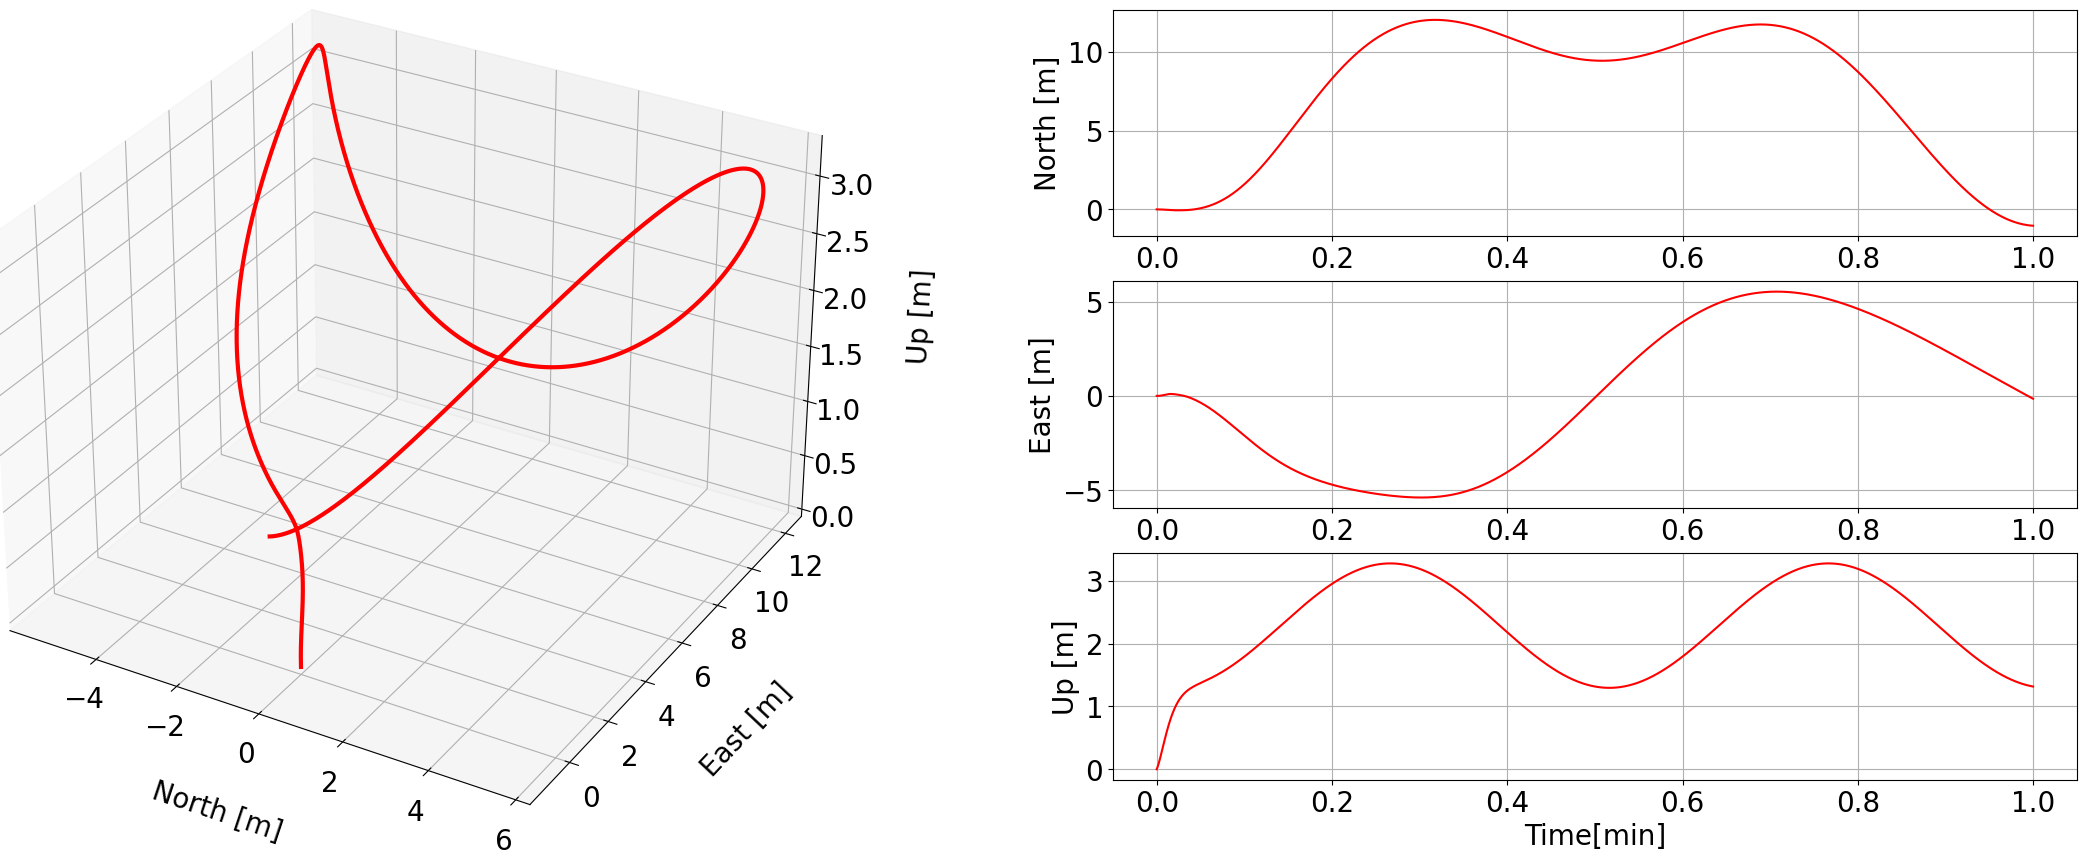

In [12]:
''' Plot 3D '''
base = (50,25,15)
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(3,7)
ax1 = fig.add_subplot(gs[:,0:4], projection='3d')
ax2 = fig.add_subplot(gs[0,4:], ylabel='North [m]')
ax2.grid()
ax3 = fig.add_subplot(gs[1,4:], ylabel='East [m]')
ax3.grid()
ax4 = fig.add_subplot(gs[2,4:], ylabel='Up [m]', xlabel="Time[min]")
ax4.grid()

ax1.set_box_aspect(aspect=None, zoom=1.2)
ax1.plot(np.array(histRealPos)[:,1],
         np.array(histRealPos)[:,0],
         np.array(histRealPos)[:,2] +abs(np.array(histRealPos)[:,2].min()), 'r', linewidth=3)
ax1.set_ylabel('East [m]', labelpad=20)
ax1.set_xlabel('North [m]', labelpad=20)
ax1.set_zlabel('Up [m]', labelpad=20)

ax2.plot(histTempo, np.array(histRealPos)[:,0], 'r')
ax3.plot(histTempo, np.array(histRealPos)[:,1], 'r')
ax4.plot(histTempo, np.array(histRealPos)[:,2] +abs(np.array(histRealPos)[:,2].min()), 'r')

plt.savefig("Images/Voo " +str(file_number) +".pdf", bbox_inches='tight')

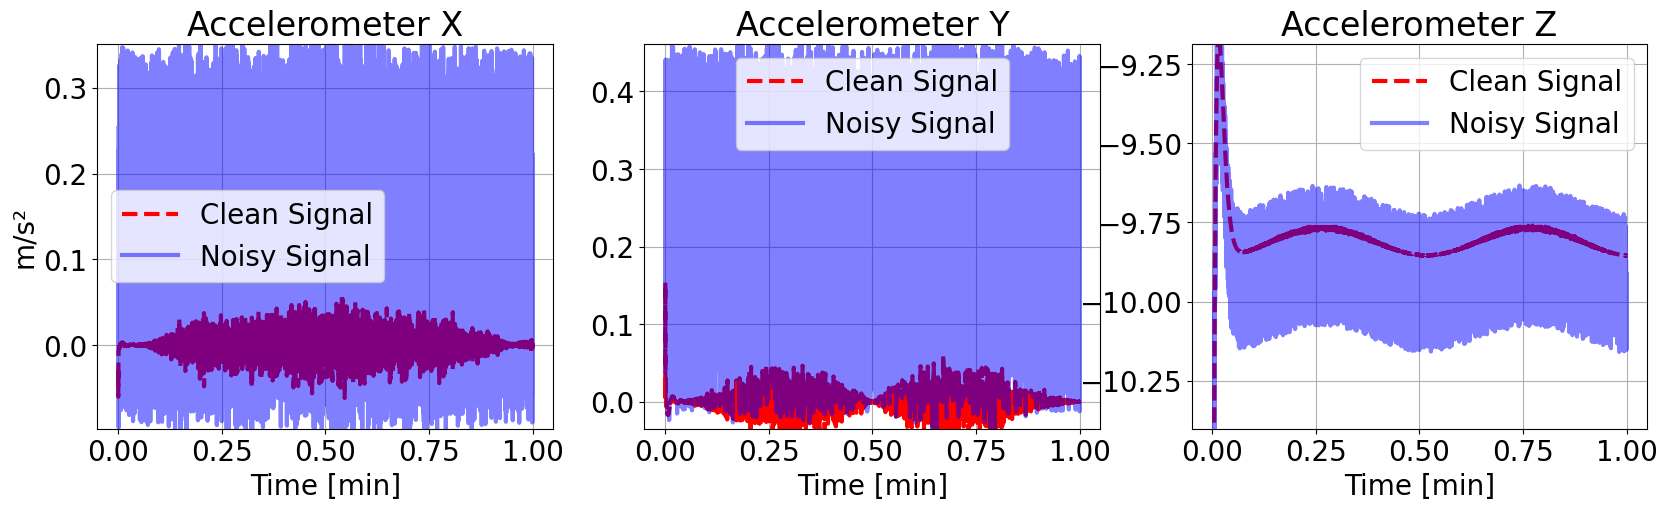

In [13]:
''' Accelerometer '''
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
ax11 = fig.add_subplot(gs[0,0], title="Accelerometer X", xlabel="Time [min]", ylabel="m/s²")
ax11.grid()
ax12 = fig.add_subplot(gs[0,1], title="Accelerometer Y", xlabel="Time [min]")
ax12.grid()
ax13 = fig.add_subplot(gs[0,2], title="Accelerometer Z", xlabel="Time [min]")
ax13.grid()

ax11.plot(histTempo, np.array(histRealAcc)[:,0], '--r', linewidth=3)
ax11.plot(histTempo, np.array(histAcc)[:,0], 'b', linewidth=3, alpha = .5)
ax11.set_ylim([np.min([np.quantile(np.array(histRealAcc)[:,0], .005), np.quantile(np.array(histAcc)[:,0], .005)]),
               np.max([np.quantile(np.array(histRealAcc)[:,0], .995), np.quantile(np.array(histAcc)[:,0], .995)])])
ax11.legend(["Clean Signal", "Noisy Signal"])
ax12.plot(histTempo, np.array(histRealAcc)[:,1], '--r', linewidth=3)
ax12.plot(histTempo, np.array(histAcc)[:,1], 'b', linewidth=3, alpha = .5)
ax12.set_ylim([np.min([np.quantile(np.array(histRealAcc)[:,1], .005), np.quantile(np.array(histAcc)[:,1], .005)]),
               np.max([np.quantile(np.array(histRealAcc)[:,1], .995), np.quantile(np.array(histAcc)[:,1], .995)])])
ax12.legend(["Clean Signal", "Noisy Signal"])
ax13.plot(histTempo, np.array(histRealAcc)[:,2], '--r', linewidth=3)
ax13.plot(histTempo, np.array(histAcc)[:,2], 'b', linewidth=3, alpha = .5)
ax13.set_ylim([np.min([np.quantile(np.array(histRealAcc)[:,2], .005), np.quantile(np.array(histAcc)[:,2], .005)]),
               np.max([np.quantile(np.array(histRealAcc)[:,2], .995), np.quantile(np.array(histAcc)[:,2], .995)])])
ax13.legend(["Clean Signal", "Noisy Signal"])

plt.savefig("Images/SensAcc " +"Cycle" +".pdf", bbox_inches='tight')

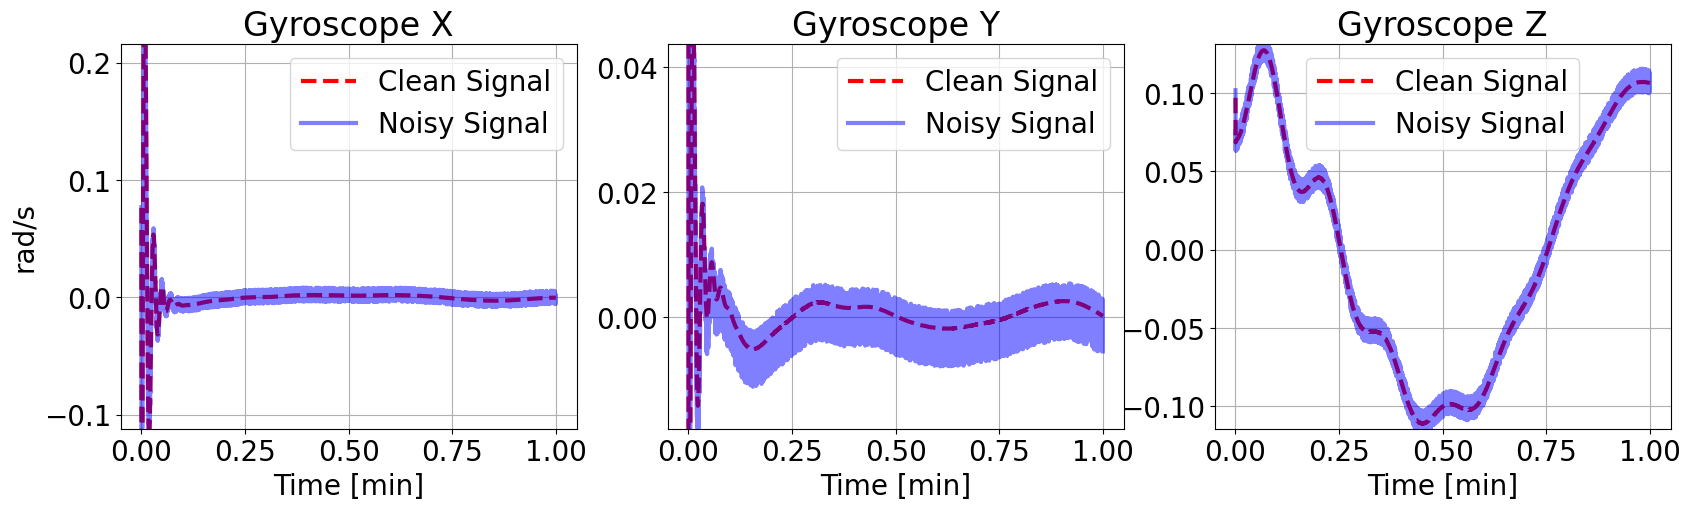

In [14]:
''' Gyroscope '''
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
ax11 = fig.add_subplot(gs[0,0], title="Gyroscope X", xlabel="Time [min]", ylabel="rad/s")
ax11.grid()
ax12 = fig.add_subplot(gs[0,1], title="Gyroscope Y", xlabel="Time [min]")
ax12.grid()
ax13 = fig.add_subplot(gs[0,2], title="Gyroscope Z", xlabel="Time [min]")
ax13.grid()

ax11.plot(histTempo, np.array(histRealGyro)[:,0], '--r', linewidth=3)
ax11.plot(histTempo, np.array(histGyro)[:,0], 'b', linewidth=3, alpha = .5)
ax11.set_ylim([np.min([np.quantile(np.array(histRealGyro)[:,0], .005), np.quantile(np.array(histGyro)[:,0], .005)]),
               np.max([np.quantile(np.array(histRealGyro)[:,0], .995), np.quantile(np.array(histGyro)[:,0], .995)])])
ax11.legend(["Clean Signal", "Noisy Signal"])
ax12.plot(histTempo, np.array(histRealGyro)[:,1], '--r', linewidth=3)
ax12.plot(histTempo, np.array(histGyro)[:,1], 'b', linewidth=3, alpha = .5)
ax12.set_ylim([np.min([np.quantile(np.array(histRealGyro)[:,1], .005), np.quantile(np.array(histGyro)[:,1], .005)]),
               np.max([np.quantile(np.array(histRealGyro)[:,1], .995), np.quantile(np.array(histGyro)[:,1], .995)])])
ax12.legend(["Clean Signal", "Noisy Signal"])
ax13.plot(histTempo, np.array(histRealGyro)[:,2], '--r', linewidth=3)
ax13.plot(histTempo, np.array(histGyro)[:,2], 'b', linewidth=3, alpha = .5)
ax13.set_ylim([np.min([np.quantile(np.array(histRealGyro)[:,2], .005), np.quantile(np.array(histGyro)[:,2], .005)]),
               np.max([np.quantile(np.array(histRealGyro)[:,2], .995), np.quantile(np.array(histGyro)[:,2], .995)])])
ax13.legend(["Clean Signal", "Noisy Signal"])

plt.savefig("Images/SensGyr " +"Cycle" +".pdf", bbox_inches='tight')

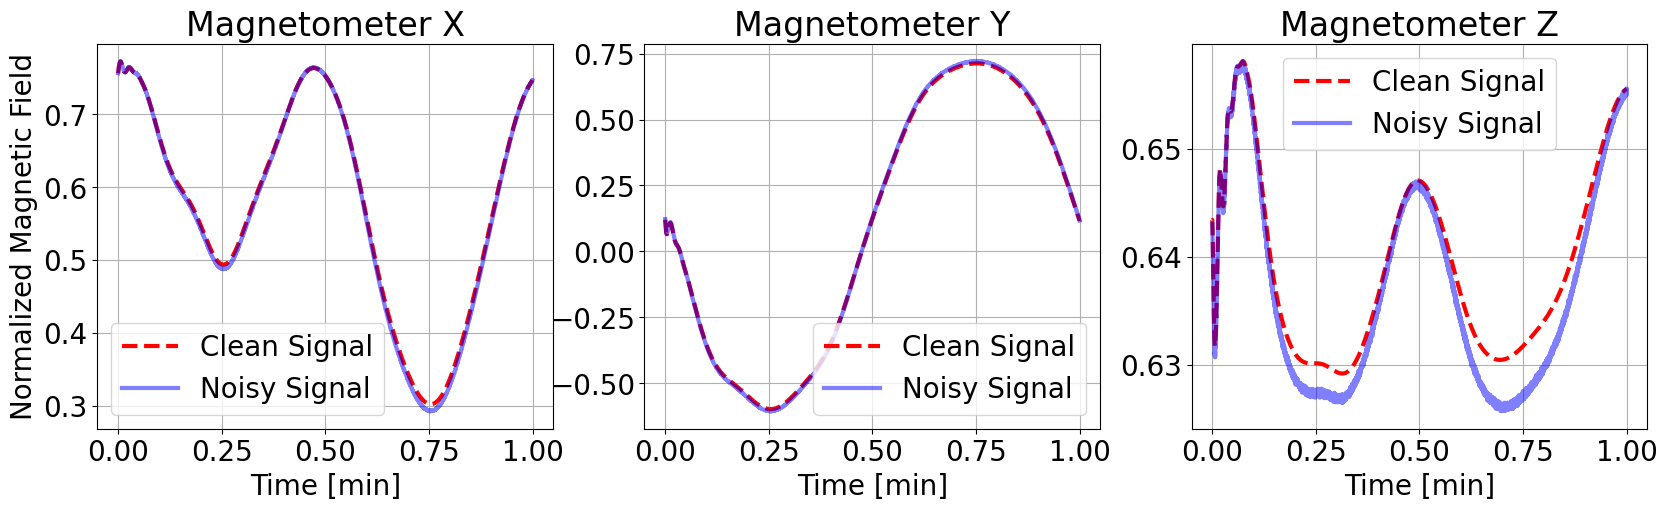

In [15]:
''' Magnetometer '''
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
ax11 = fig.add_subplot(gs[0,0], title="Magnetometer X", xlabel="Time [min]", ylabel="Normalized Magnetic Field")
ax11.grid()
ax12 = fig.add_subplot(gs[0,1], title="Magnetometer Y", xlabel="Time [min]")
ax12.grid()
ax13 = fig.add_subplot(gs[0,2], title="Magnetometer Z", xlabel="Time [min]")
ax13.grid()

ax11.plot(histTempo, np.array(histRealMag)[:,0], '--r', linewidth=3)
ax11.plot(histTempo, np.array(histMag)[:,0], 'b', linewidth=3, alpha = .5)
ax11.legend(["Clean Signal", "Noisy Signal"])
ax12.plot(histTempo, np.array(histRealMag)[:,1], '--r', linewidth=3)
ax12.plot(histTempo, np.array(histMag)[:,1], 'b', linewidth=3, alpha = .5)
ax12.legend(["Clean Signal", "Noisy Signal"])
ax13.plot(histTempo, np.array(histRealMag)[:,2], '--r', linewidth=3)
ax13.plot(histTempo, np.array(histMag)[:,2], 'b', linewidth=3, alpha = .5)
ax13.legend(["Clean Signal", "Noisy Signal"])

plt.savefig("Images/SensMag " +"Cycle" +".pdf", bbox_inches='tight')

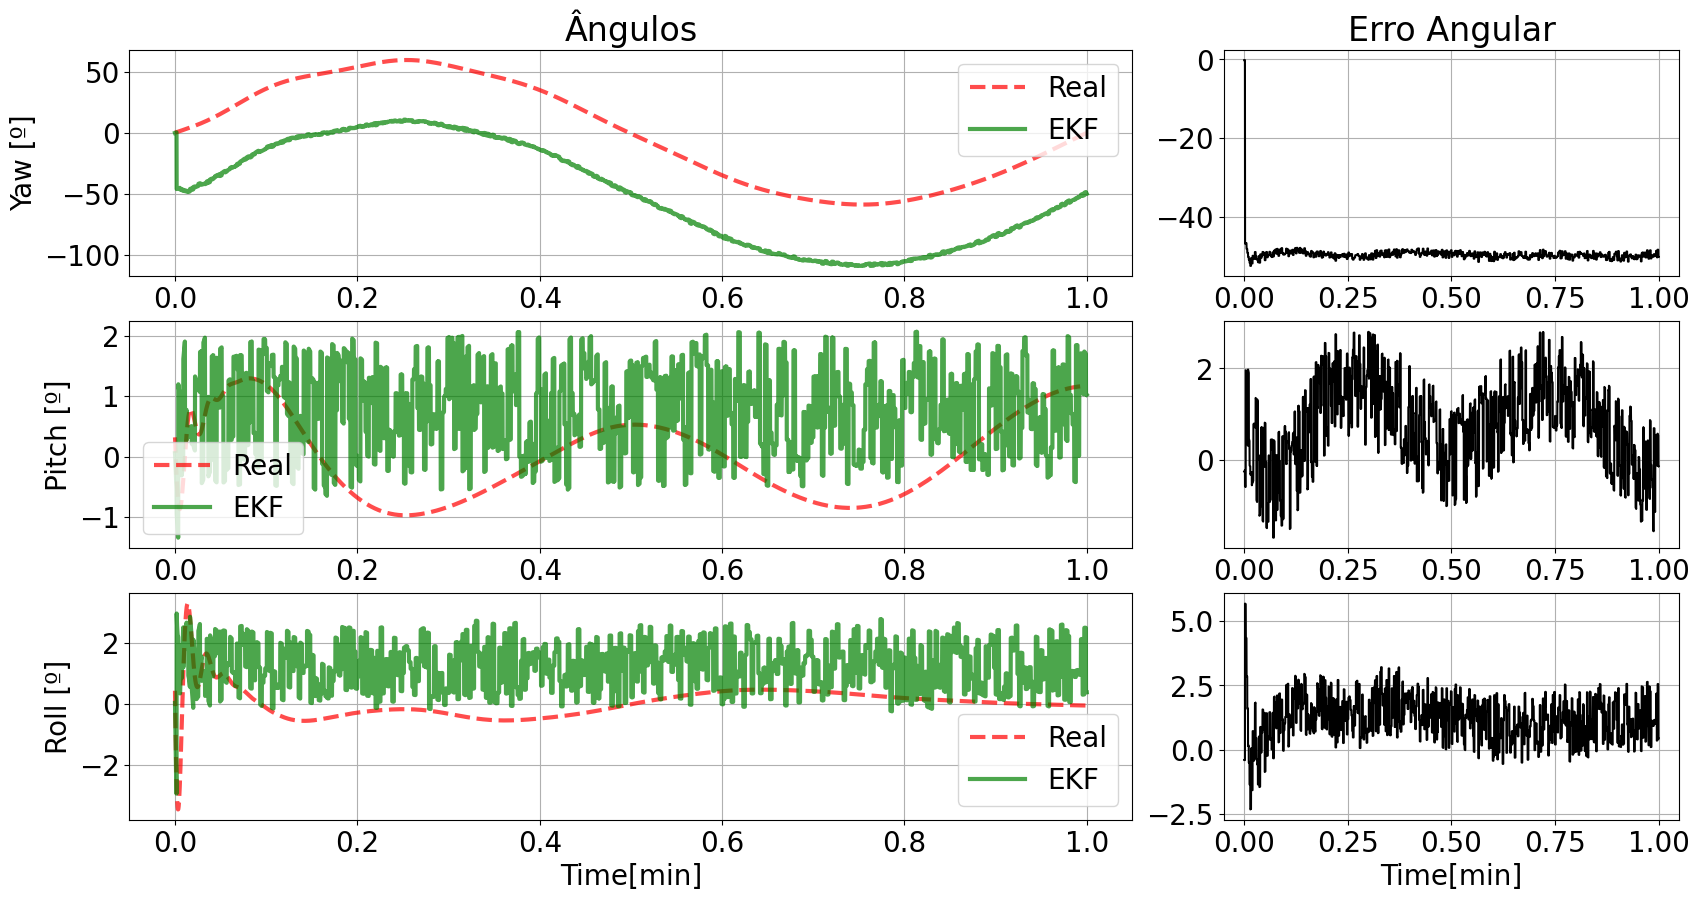

In [16]:
fig = plt.figure(figsize=(20,10))

gs = fig.add_gridspec(3,3)
ax11 = fig.add_subplot(gs[0,0:2], ylabel="Yaw [º]", title="Ângulos")
ax11.grid()
ax12 = fig.add_subplot(gs[1,0:2], ylabel="Pitch [º]")
ax12.grid()
ax13 = fig.add_subplot(gs[2,0:2], ylabel="Roll [º]", xlabel="Time[min]")
ax13.grid()
ax21 = fig.add_subplot(gs[0,-1], title="Erro Angular")
ax21.grid()
ax22 = fig.add_subplot(gs[1,-1])
ax22.grid()
ax23 = fig.add_subplot(gs[2,-1], xlabel="Time[min]")
ax23.grid()

''' Ângulos '''
ax11.plot(histTempo, np.rad2deg(histRealAng)[:,0], '--r',
          histTempo, np.rad2deg(histAng)[:,0], 'g', alpha=.7, linewidth=3)
ax11.legend(["Real", "EKF"])

ax12.plot(histTempo, np.rad2deg(histRealAng)[:,1], '--r',
          histTempo, np.rad2deg(histAng)[:,1], 'g', alpha=.7, linewidth=3)
ax12.legend(["Real", "EKF"])

ax13.plot(histTempo, np.rad2deg(histRealAng)[:,2], '--r',
          histTempo, np.rad2deg(histAng)[:,2], 'g', alpha=.7, linewidth=3)
ax13.legend(["Real", "EKF"])


''' Erro do Ângulos '''
erroAngX = np.array(histAng) -np.array(histRealAng)
for index, val in np.ndenumerate(erroAngX):
    if abs(val)>np.pi:
        erroAngX[index] = val-np.sign(val)*2*np.pi
erroAngX = np.rad2deg(erroAngX)

ax21.plot(histTempo, erroAngX[:,0], 'k')
ax22.plot(histTempo, erroAngX[:,1], 'k')
ax23.plot(histTempo, erroAngX[:,2], 'k')

plt.savefig("Images/Ang " +str(file_number) +".pdf", bbox_inches='tight')

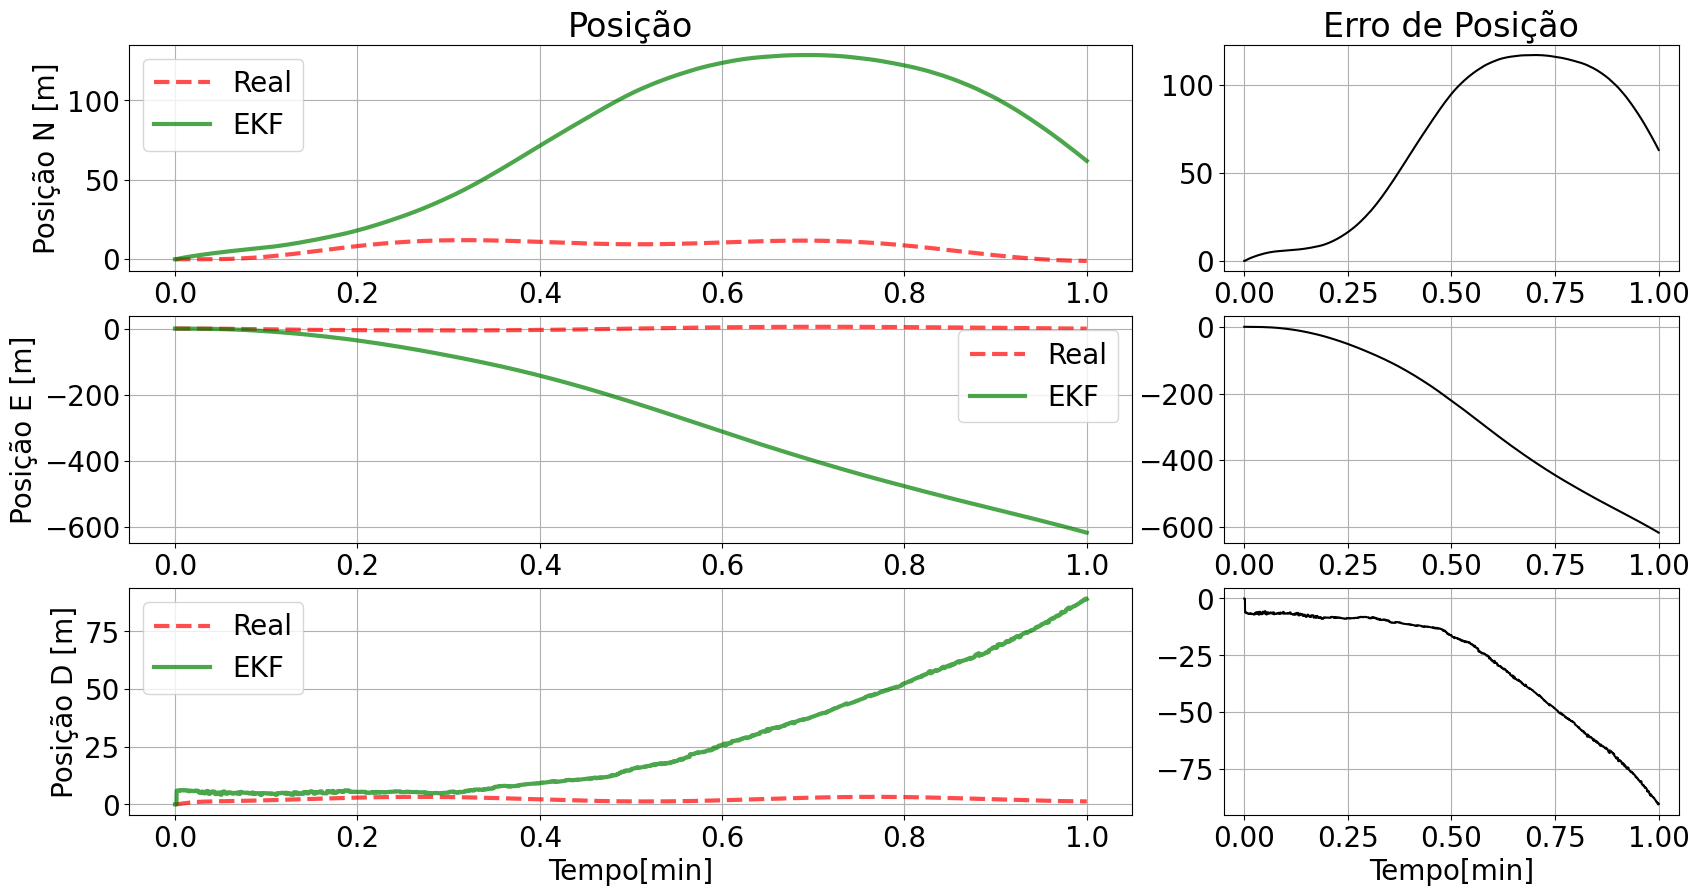

In [17]:
fig = plt.figure(figsize=(20,10))

gs = fig.add_gridspec(3,3)
ax11 = fig.add_subplot(gs[0,0:2], ylabel="Posição N [m]", title="Posição")
ax11.grid()
ax12 = fig.add_subplot(gs[1,0:2], ylabel="Posição E [m]")
ax12.grid()
ax13 = fig.add_subplot(gs[2,0:2], ylabel="Posição D [m]", xlabel="Tempo[min]")
ax13.grid()
ax21 = fig.add_subplot(gs[0,-1], title="Erro de Posição")
ax21.grid()
ax22 = fig.add_subplot(gs[1,-1])
ax22.grid()
ax23 = fig.add_subplot(gs[2,-1], xlabel="Tempo[min]")
ax23.grid()

''' Posição '''
ax11.plot(histTempo, np.array(histRealPos)[:,0], '--r',
          histTempo, np.array(histPos)[:,0], 'g',
          alpha=.7, linewidth=3)
ax11.legend(["Real", "EKF"])

ax12.plot(histTempo, np.array(histRealPos)[:,1], '--r',
          histTempo, np.array(histPos)[:,1], 'g',
          alpha=.7, linewidth=3)
ax12.legend(["Real", "EKF"])

ax13.plot(histTempo, np.array(histRealPos)[:,2] +abs(np.array(histRealPos)[:,2].min()), '--r',
          histTempo, -np.array(histPos)[:,2] -abs(np.array(histRealPos)[:,2].min()), 'g',
          alpha=.7, linewidth=3)
ax13.legend(["Real", "EKF"])


''' Erro do Ângulos '''
erroPos = np.array(histPos)-np.array(histRealPos)

ax21.plot(histTempo, erroPos[:,0], 'k')
ax22.plot(histTempo, erroPos[:,1], 'k')
ax23.plot(histTempo, erroPos[:,2], 'k')

plt.savefig("Images/Pos " +str(file_number) +".pdf", bbox_inches='tight')

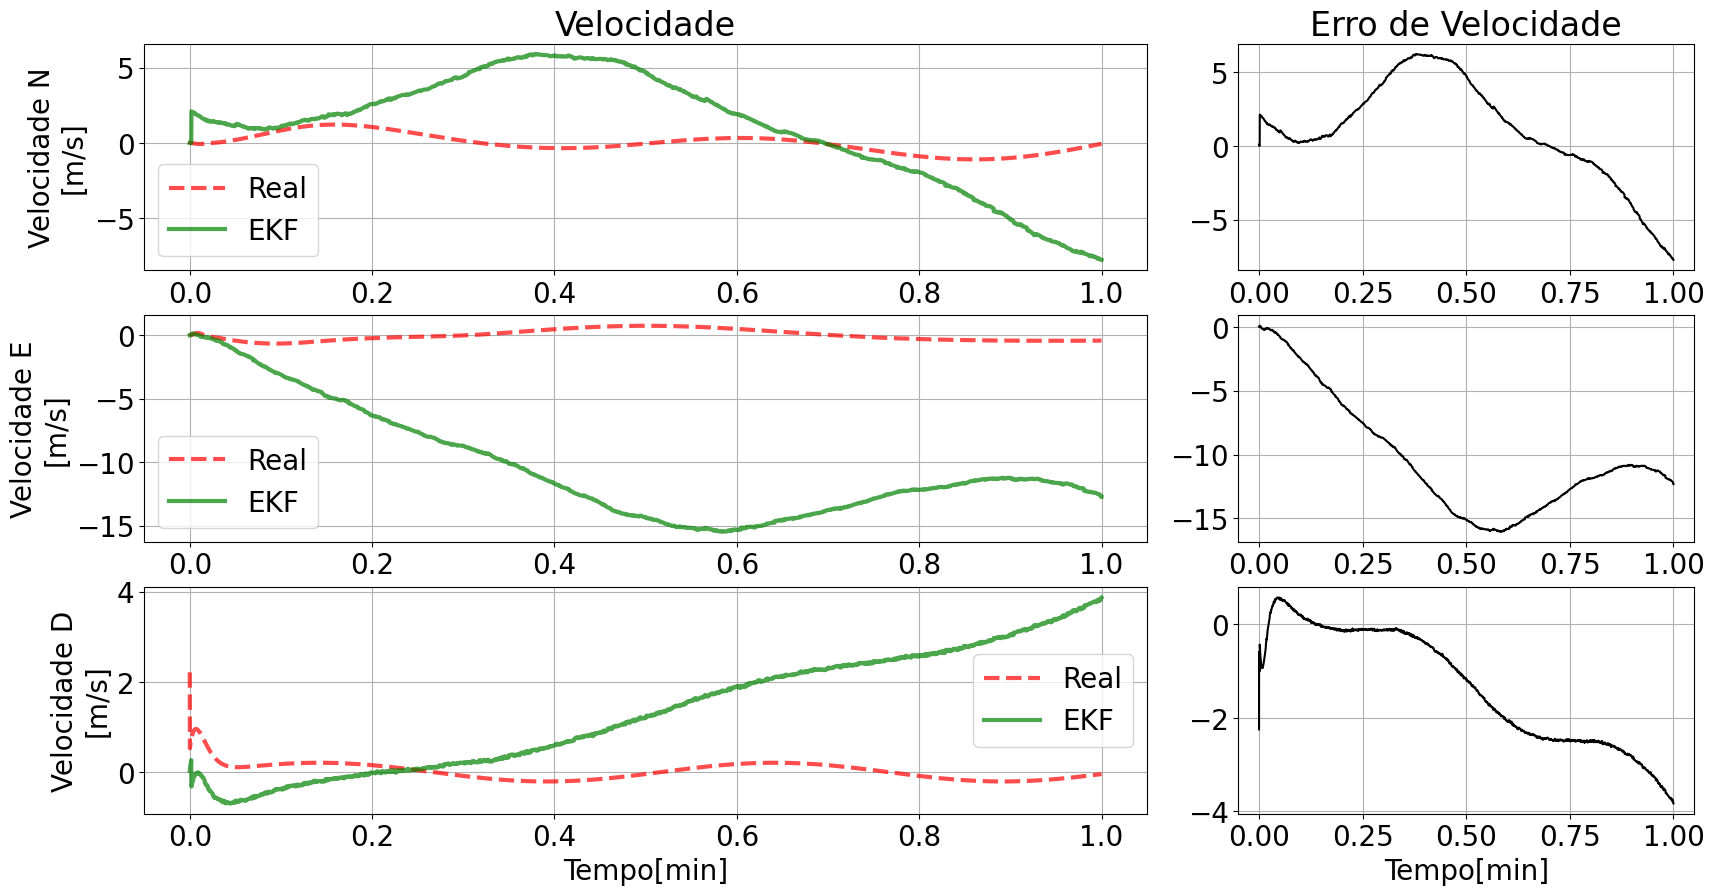

In [18]:
fig = plt.figure(figsize=(20,10))

gs = fig.add_gridspec(3,3)
ax11 = fig.add_subplot(gs[0,0:2], ylabel="Velocidade N\n[m/s]", title="Velocidade")
ax11.grid()
ax12 = fig.add_subplot(gs[1,0:2], ylabel="Velocidade E\n[m/s]")
ax12.grid()
ax13 = fig.add_subplot(gs[2,0:2], ylabel="Velocidade D\n[m/s]", xlabel="Tempo[min]")
ax13.grid()
ax21 = fig.add_subplot(gs[0,-1], title="Erro de Velocidade")
ax21.grid()
ax22 = fig.add_subplot(gs[1,-1])
ax22.grid()
ax23 = fig.add_subplot(gs[2,-1], xlabel="Tempo[min]")
ax23.grid()

''' Velocidade '''
ax11.plot(histTempo, np.array(histRealVel)[:,0], '--r',
          histTempo, np.array(histVel)[:,0], 'g', alpha=.7, linewidth=3)
ax11.legend(["Real", "EKF"])

ax12.plot(histTempo, np.array(histRealVel)[:,1], '--r',
          histTempo, np.array(histVel)[:,1], 'g', alpha=.7, linewidth=3)
ax12.legend(["Real", "EKF"])

ax13.plot(histTempo, np.array(histRealVel)[:,2], '--r',
          histTempo, -np.array(histVel)[:,2], 'g', alpha=.7, linewidth=3)
ax13.legend(["Real", "EKF"])


''' Erro do Ângulos '''
erroVel = np.array(histVel)-np.array(histRealVel)

ax21.plot(histTempo, erroVel[:,0], 'k')
ax22.plot(histTempo, erroVel[:,1], 'k')
ax23.plot(histTempo, erroVel[:,2], 'k')

plt.savefig("Images/Vel " +str(file_number) +".pdf", bbox_inches='tight')

---
# **Plots**

## ***Tempo***

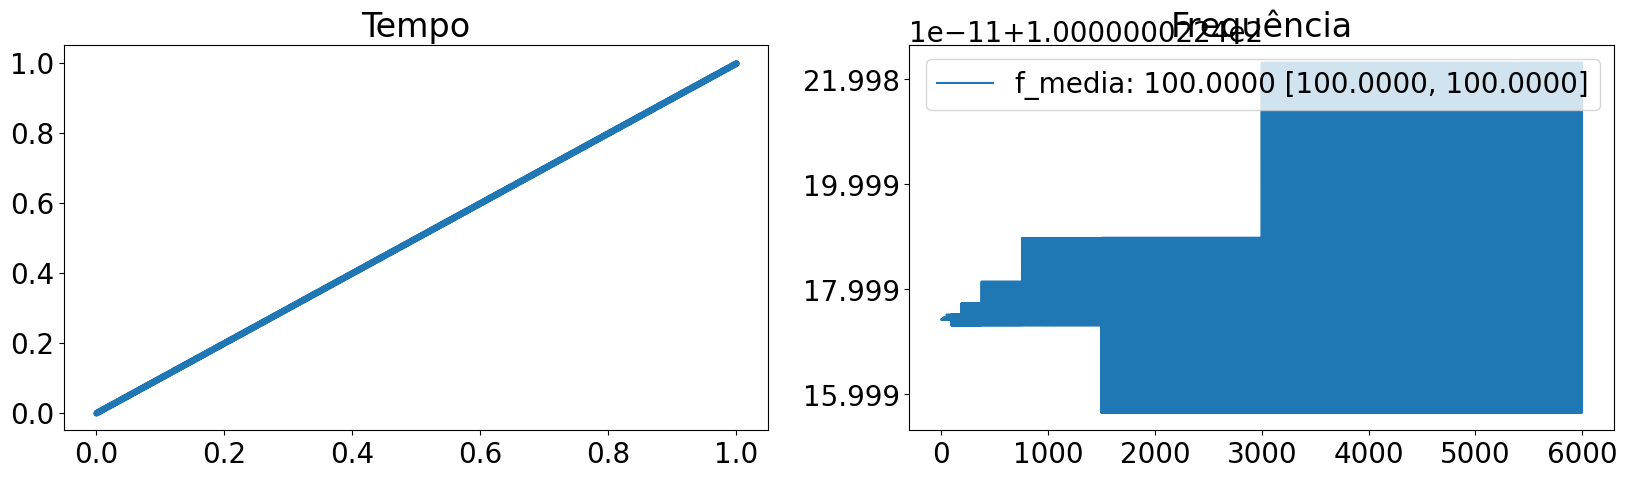

In [19]:
fig = plt.figure(figsize=(20,5))
ax11 = fig.add_subplot(1,2,1, title="Tempo")
ax11.scatter(histTempo, histTempo, marker='.', linewidth=1)

dTempo = 60*(np.array(histTempo[1:-1]) -np.array(histTempo[0:-2]))
freq = 1/dTempo[1:]
ax21 = fig.add_subplot(1,2,2, title="Frequência")
ax21.plot(freq, label="f_media: %0.4f [%0.4f, %0.4f]" %(np.mean(freq), np.min(freq), np.max(freq)))
ax21.legend()

## ***Aceleração e Giro***

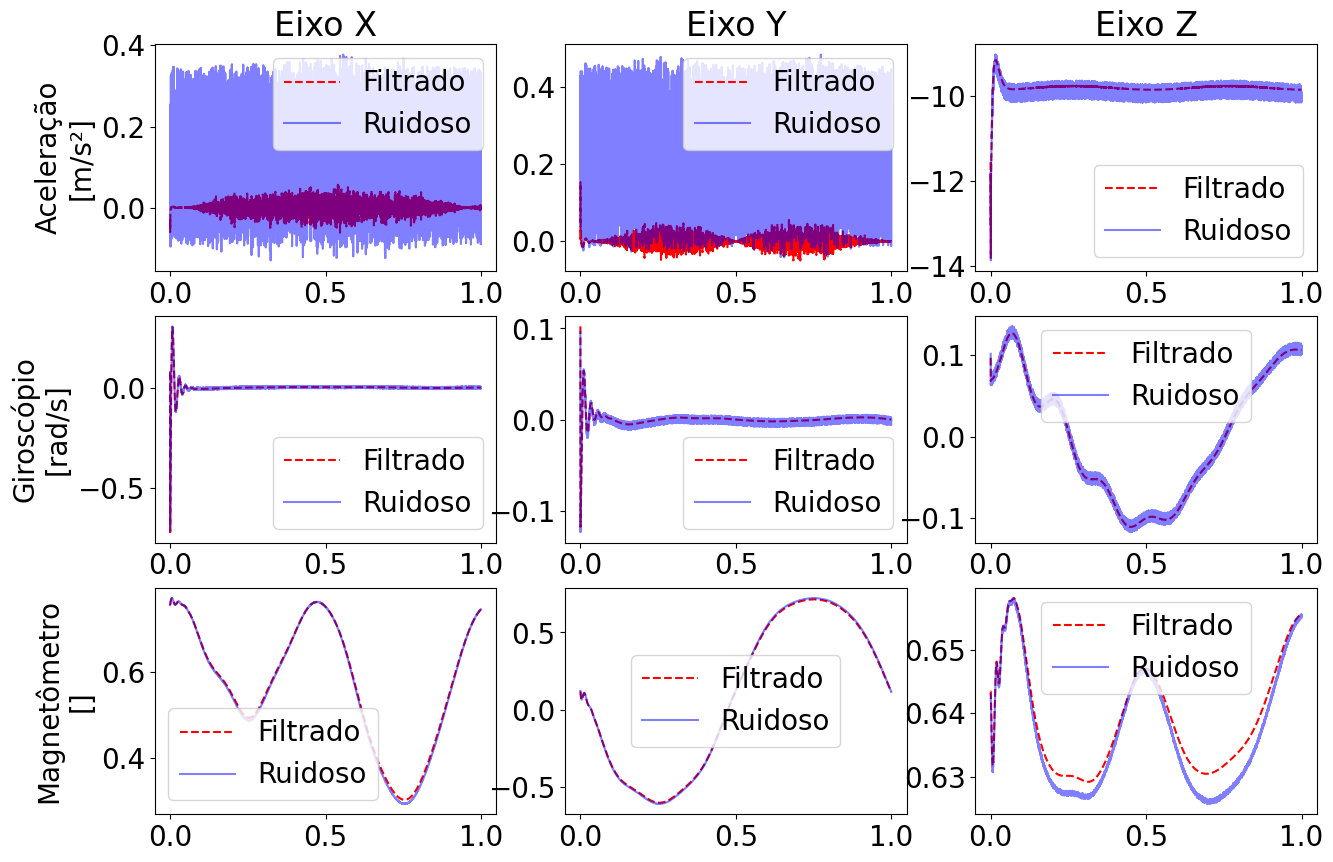

In [20]:
fig = plt.figure(figsize=(15,10))
ax11 = fig.add_subplot(3,3,1, title="Eixo X", ylabel="Aceleração\n[m/s²]")
ax11.plot(histTempo, np.array(histRealAcc)[:,0], '--r')
ax11.plot(histTempo, np.array(histAcc)[:,0], 'b', alpha = .5)
ax11.legend(["Filtrado", "Ruidoso"])
ax12 = fig.add_subplot(3,3,2, title="Eixo Y")
ax12.plot(histTempo, np.array(histRealAcc)[:,1], '--r')
ax12.plot(histTempo, np.array(histAcc)[:,1], 'b', alpha = .5)
ax12.legend(["Filtrado", "Ruidoso"])
ax13 = fig.add_subplot(3,3,3, title="Eixo Z")
ax13.plot(histTempo, np.array(histRealAcc)[:,2], '--r')
ax13.plot(histTempo, np.array(histAcc)[:,2], 'b', alpha = .5)
ax13.legend(["Filtrado", "Ruidoso"])

ax21 = fig.add_subplot(3,3,4, ylabel="Giroscópio\n[rad/s]")
ax21.plot(histTempo, np.array(histRealGyro)[:,0], '--r')
ax21.plot(histTempo, np.array(histGyro)[:,0], 'b', alpha = .5)
ax21.legend(["Filtrado", "Ruidoso"])
ax22 = fig.add_subplot(3,3,5)
ax22.plot(histTempo, np.array(histRealGyro)[:,1], '--r')
ax22.plot(histTempo, np.array(histGyro)[:,1], 'b', alpha = .5)
ax22.legend(["Filtrado", "Ruidoso"])
ax23 = fig.add_subplot(3,3,6)
ax23.plot(histTempo, np.array(histRealGyro)[:,2], '--r')
ax23.plot(histTempo, np.array(histGyro)[:,2], 'b', alpha = .5)
ax23.legend(["Filtrado", "Ruidoso"])

ax31 = fig.add_subplot(3,3,7, ylabel="Magnetômetro\n[]")
ax31.plot(histTempo, np.array(histRealMag)[:,0], '--r')
ax31.plot(histTempo, np.array(histMag)[:,0], 'b', alpha = .5)
ax31.legend(["Filtrado", "Ruidoso"])
ax32 = fig.add_subplot(3,3,8)
ax32.plot(histTempo, np.array(histRealMag)[:,1], '--r')
ax32.plot(histTempo, np.array(histMag)[:,1], 'b', alpha = .5)
ax32.legend(["Filtrado", "Ruidoso"])
ax33 = fig.add_subplot(3,3,9)
ax33.plot(histTempo, np.array(histRealMag)[:,2], '--r')
ax33.plot(histTempo, np.array(histMag)[:,2], 'b', alpha = .5)
ax33.legend(["Filtrado", "Ruidoso"])

# #("Images/Sens" + save_File +"_" +str(file_number) +".jpg", bbox_inches='tight')

## ***NNBO***

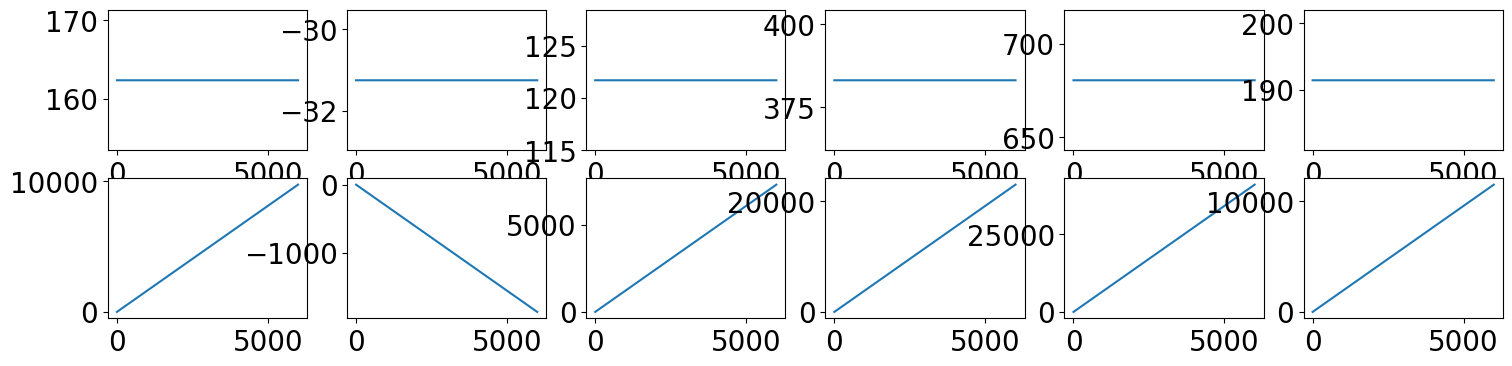

In [21]:
nrows = 2
ncols = 6
fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols,2*nrows))
ax = ax.ravel()

Int_NNBO = np.zeros([len(histNNBO), 6])
for index, val in enumerate(np.array(histNNBO)[1:]):
    Int_NNBO[index+1] = Int_NNBO[index] +val*dt

for i in range(6):
    ax[i].plot(np.array(histNNBO)[:, i])
    ax[i+6].plot(Int_NNBO[:, i])

## ***Ângulos***

(-2.3257183077063126, 5.687780973404093)

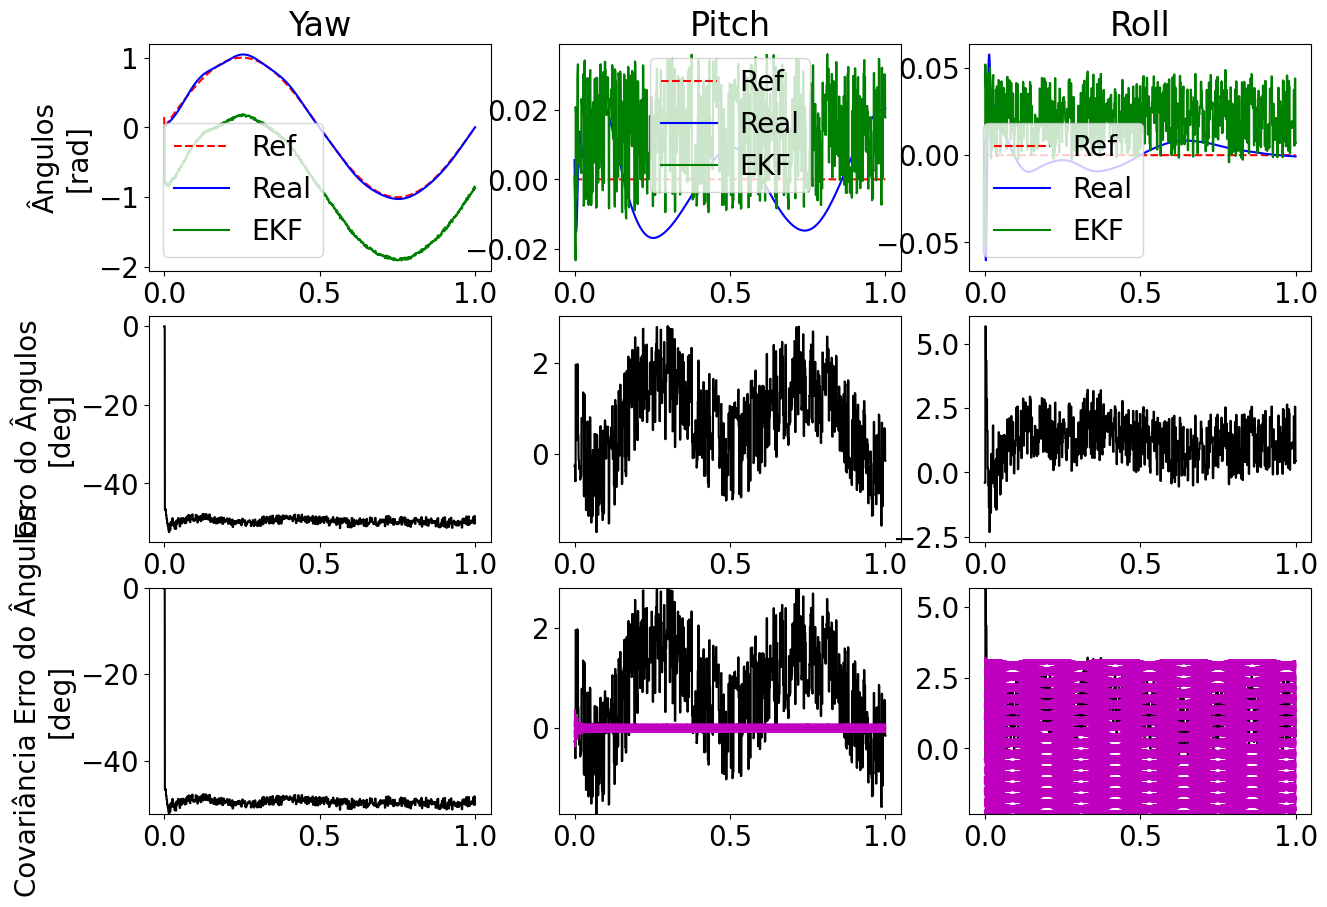

In [22]:
fig = plt.figure(figsize=(15,10))

''' Ângulos '''
ax11 = fig.add_subplot(3,3,1, title="Yaw", ylabel="Ângulos\n[rad]")
ax11.plot(histTempo, np.array(histRefAng)[:,2], '--r',
          histTempo, np.array(histRealAng)[:,0], 'b',
          histTempo, np.array(histAng)[:,0], 'g', alpha=1)
# ax11.plot(histTempo, np.array(histAng)[:,0] +np.array(histP)[:,6], '--m')
# ax11.plot(histTempo, np.array(histAng)[:,0] -np.array(histP)[:,6], '--m')
# ax11.set_ylim([-np.pi, np.pi])
ax11.legend(["Ref", "Real", "EKF"])

ax12 = fig.add_subplot(3,3,2, title="Pitch")
ax12.plot(histTempo, np.array(histRefAng)[:,1], '--r',
          histTempo, np.array(histRealAng)[:,1], 'b',
          histTempo, np.array(histAng)[:,1], 'g', alpha=1)
# ax12.plot(histTempo, np.array(histAng)[:,1] +np.array(histP)[:,7], '--m')
# ax12.plot(histTempo, np.array(histAng)[:,1] -np.array(histP)[:,7], '--m')
# ax12.set_ylim([-np.pi/2, np.pi/2])
ax12.legend(["Ref", "Real", "EKF"])

ax13 = fig.add_subplot(3,3,3, title="Roll")
ax13.plot(histTempo, np.array(histRefAng)[:,0], '--r',
          histTempo, np.array(histRealAng)[:,2], 'b',
          histTempo, np.array(histAng)[:,2], 'g', alpha=1)
# ax13.plot(histTempo, np.array(histAng)[:,2] +np.array(histP)[:,8], '--m')
# ax13.plot(histTempo, np.array(histAng)[:,2] -np.array(histP)[:,8], '--m')
# ax13.set_ylim([-np.pi, np.pi])
ax13.legend(["Ref", "Real", "EKF"])


''' Erro do Ângulos '''
erroAngX = np.array(histAng) -np.array(histRealAng)
for index, val in np.ndenumerate(erroAngX):
    if abs(val)>np.pi:
        erroAngX[index] = val-np.sign(val)*2*np.pi
erroAngX = np.rad2deg(erroAngX)

ax21 = fig.add_subplot(3,3,4, ylabel="Erro do Ângulos\n[deg]")
ax21.plot(histTempo, erroAngX[:,0], 'k')
ax22 = fig.add_subplot(3,3,5)
ax22.plot(histTempo, erroAngX[:,1], 'k')
ax23 = fig.add_subplot(3,3,6)
ax23.plot(histTempo, erroAngX[:,2], 'k')


''' Covariância Erro do Ângulos '''
ax31 = fig.add_subplot(3,3,7, ylabel="Covariância Erro do Ângulos\n[deg]")
ax31.plot(histTempo, erroAngX[:,0], 'k')
ax31.plot(histTempo, +np.array(histP)[:,6], '--m')
ax31.plot(histTempo, -np.array(histP)[:,6], '--m')
ax31.set_ylim([np.min([np.min(np.array(erroAngX)[:,0]), 
                       -np.quantile(np.array(histP)[:,6], .25)]), 
               np.max([np.max(np.array(erroAngX)[:,0]), 
                       +np.quantile(np.array(histP)[:,6], .25)])])

ax32 = fig.add_subplot(3,3,8)
ax32.plot(histTempo, erroAngX[:,1], 'k')
ax32.plot(histTempo, +np.array(histP)[:,7], '--m')
ax32.plot(histTempo, -np.array(histP)[:,7], '--m')
ax32.set_ylim([np.min([np.min(np.array(erroAngX)[:,1]), 
                       -np.quantile(np.array(histP)[:,7], .25)]), 
               np.max([np.max(np.array(erroAngX)[:,1]), 
                       +np.quantile(np.array(histP)[:,7], .25)])])

ax33 = fig.add_subplot(3,3,9)
ax33.plot(histTempo, erroAngX[:,2], 'k')
ax33.plot(histTempo, +np.array(histP)[:,8], '--m')
ax33.plot(histTempo, -np.array(histP)[:,8], '--m')
ax33.set_ylim([np.min([np.min(np.array(erroAngX)[:,2]), 
                       -np.quantile(np.array(histP)[:,8], .25)]), 
               np.max([np.max(np.array(erroAngX)[:,2]), 
                       +np.quantile(np.array(histP)[:,8], .25)])])

# #("Images/Ang" + save_File +"_" +str(file_number) +".jpg", bbox_inches='tight')

## ***Posição e Velocidade***

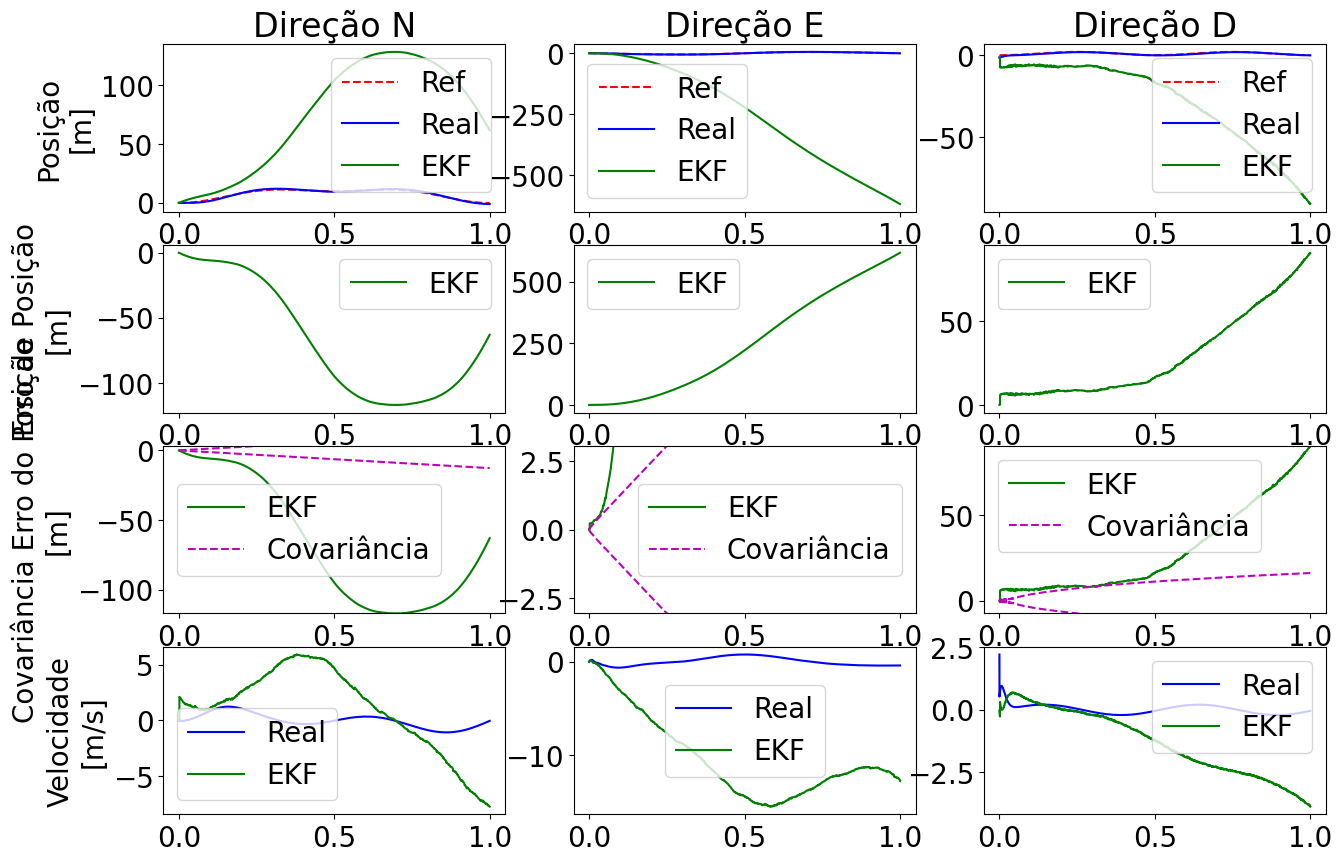

In [23]:
fig = plt.figure(figsize=(15,10))

''' Posição '''
ax11 = fig.add_subplot(4,3,1, title="Direção N", ylabel="Posição\n[m]")
ax11.plot(histTempo, np.array(histRefPos)[:,0], '--r',
          histTempo, np.array(histRealPos)[:,0], 'b',
          # histTempo, Int_NNBO[:,0], 'c',
          histTempo, np.array(histPos)[:,0], 'g', alpha=1)
# ax11.plot(np.array(histCorrPos)[:,0], np.array(histCorrPos)[:,1], 'xk')
# ax11.plot(np.array(histGPS)[:,0], np.array(histGPS)[:,1], 'ok')
# ax11.plot(histTempo, np.array(histPos)[:,0] +np.array(histP)[:,0], '--m')
# ax11.plot(histTempo, np.array(histPos)[:,0] -np.array(histP)[:,0], '--m')
# ax11.set_ylim([np.min([np.min([np.array(histRealPos)[:,0], np.array(histPos)[:,0]]), 
#                        -np.quantile(np.array(histP)[:,0], .25)]), 
#                np.max([np.max([np.array(histRealPos)[:,0], np.array(histPos)[:,0]]), 
#                        +np.quantile(np.array(histP)[:,0], .25)])])
ax11.legend(["Ref", "Real", 
             # "NNBO",
             "EKF",
             "GPS"])

ax12 = fig.add_subplot(4,3,2, title="Direção E")
ax12.plot(histTempo, np.array(histRefPos)[:,1], '--r',
          histTempo, np.array(histRealPos)[:,1], 'b',
          # histTempo, Int_NNBO[:,1], 'c',
          histTempo, np.array(histPos)[:,1], 'g', alpha=1)
# ax12.plot(np.array(histCorrPos)[:,0], np.array(histCorrPos)[:,2], 'xk')
# ax12.plot(np.array(histGPS)[:,0], np.array(histGPS)[:,2], 'ok')
# ax12.plot(histTempo, np.array(histPos)[:,1] +np.array(histP)[:,1], '--m')
# ax12.plot(histTempo, np.array(histPos)[:,1] -np.array(histP)[:,1], '--m')
# ax12.set_ylim([np.min([np.min([np.array(histRealPos)[:,1], np.array(histPos)[:,1]]), 
#                        -np.quantile(np.array(histP)[:,1], .25)]), 
#                np.max([np.max([np.array(histRealPos)[:,1], np.array(histPos)[:,1]]), 
#                        +np.quantile(np.array(histP)[:,1], .25)])])
ax12.legend(["Ref", "Real",
             # "NNBO", 
             "EKF",
             "GPS"])

ax13 = fig.add_subplot(4,3,3, title="Direção D")
ax13.plot(histTempo, np.array(histRefPos)[:,2], '--r',
          histTempo, np.array(histRealPos)[:,2], 'b',
          # histTempo, Int_NNBO[:,2], 'c',
          histTempo, np.array(histPos)[:,2], 'g', alpha=1)
# ax13.plot(np.array(histCorrPos)[:,0], np.array(histCorrPos)[:,3], 'xk')
# ax13.plot(np.array(histGPS)[:,0], np.array(histGPS)[:,3], 'ok')
# ax13.plot(histTempo, np.array(histPos)[:,2] +np.array(histP)[:,2], '--m')
# ax13.plot(histTempo, np.array(histPos)[:,2] -np.array(histP)[:,2], '--m')
# ax13.set_ylim([np.min([np.min([np.array(histRealPos)[:,2], np.array(histPos)[:,2]]), 
#                        -np.quantile(np.array(histP)[:,2], .25)]), 
#                np.max([np.max([np.array(histRealPos)[:,2], np.array(histPos)[:,2]]), 
#                        +np.quantile(np.array(histP)[:,2], .25)])])
ax13.legend(["Ref", "Real", 
             # "NNBO",
             "EKF",
             "GPS"])


''' Erro de Posição '''
Erro_Pos_NNBO = np.array(histRealPos)[:]-Int_NNBO[:,:3]
Erro_Pos_EKF = np.array(histRealPos)[:]-np.array(histPos)[:]

ax21 = fig.add_subplot(4,3,4, ylabel="Erro de Posição\n[m]")
ax21.plot(# histTempo, Erro_Pos_NNBO[:,0], 'c',
          histTempo, Erro_Pos_EKF[:,0], 'g')
ax21.legend([# "NNBO", 
             "EKF"])
ax22 = fig.add_subplot(4,3,5)
ax22.plot(# histTempo, Erro_Pos_NNBO[:,1], 'c',
          histTempo, Erro_Pos_EKF[:,1], 'g')
ax22.legend([# "NNBO", 
             "EKF"])
ax23 = fig.add_subplot(4,3,6)
ax23.plot(# histTempo, Erro_Pos_NNBO[:,2], 'c',
          histTempo, Erro_Pos_EKF[:,2], 'g')
ax23.legend([# "NNBO", 
             "EKF"])


''' Covariância Erro do Posição '''
ax31 = fig.add_subplot(4,3,7, ylabel="Covariância Erro do Posição\n[m]")
ax31.plot(# histTempo, Erro_Pos_NNBO[:,0], 'c',
          histTempo, Erro_Pos_EKF[:,0], 'g',
          histTempo, +np.array(histP)[:,0], '--m',
          histTempo, -np.array(histP)[:,0], '--m')
ax31.set_ylim([np.min([np.min(Erro_Pos_EKF[:,0]),
                       -np.quantile(np.array(histP)[:,0], .25)]), 
               np.max([np.max(Erro_Pos_EKF[:,0]), 
                       +np.quantile(np.array(histP)[:,0], .25)])])
ax31.legend([# "NNBO", 
             "EKF", 
             "Covariância"])

ax32 = fig.add_subplot(4,3,8)
ax32.plot(# histTempo, Erro_Pos_NNBO[:,1], 'c',
          histTempo, Erro_Pos_EKF[:,1], 'g',
          histTempo, +np.array(histP)[:,1], '--m',
          histTempo, -np.array(histP)[:,1], '--m')
ax32.set_ylim([np.min([np.min(Erro_Pos_EKF[:,1]),
                       -np.quantile(np.array(histP)[:,1], .25)]), 
               np.max([np.min(Erro_Pos_EKF[:,1]),
                       +np.quantile(np.array(histP)[:,1], .25)])])
ax32.legend([# "NNBO", 
             "EKF", 
             "Covariância"])

ax33 = fig.add_subplot(4,3,9)
ax33.plot(# histTempo, Erro_Pos_NNBO[:,2], 'c',
          histTempo, Erro_Pos_EKF[:,2], 'g',
          histTempo, +np.array(histP)[:,2], '--m',
          histTempo, -np.array(histP)[:,2], '--m')
ax33.set_ylim([np.min([np.min(Erro_Pos_EKF[:,2]),
                       -np.quantile(np.array(histP)[:,2], .25)]), 
               np.max([np.max(Erro_Pos_EKF[:,2]),
                       +np.quantile(np.array(histP)[:,2], .25)])])
ax33.legend([# "NNBO", 
             "EKF", 
             "Covariância"])


''' Velocidade '''
ax41 = fig.add_subplot(4,3,10, ylabel="Velocidade\n[m/s]")
ax41.plot(histTempo, np.array(histRealVel)[:,0], 'b',
          # histTempo, np.array(histNNBO)[:,0], 'c',
          histTempo, np.array(histVel)[:,0], 'g'
         )
# ax41.plot(histTempo, np.array(histVel)[:,0] +np.array(histP)[:,3], '--m')
# ax41.plot(histTempo, np.array(histVel)[:,0] -np.array(histP)[:,3], '--m')
# ax41.set_ylim([np.min([np.min(np.array(histVel)[:,0]), 
#                        -np.quantile(np.array(histP)[:,3], .25)]), 
#                np.max([np.max(np.array(histVel)[:,0]), 
#                        +np.quantile(np.array(histP)[:,3], .25)])])
ax41.legend(["Real",
             # "NNBO", 
             "EKF"])

ax42 = fig.add_subplot(4,3,11)
ax42.plot(histTempo, np.array(histRealVel)[:,1], 'b',
          # histTempo, np.array(histNNBO)[:,1], 'c',
          histTempo, np.array(histVel)[:,1], 'g'
         )
# ax42.plot(histTempo, np.array(histVel)[:,1] +np.array(histP)[:,4], '--m')
# ax42.plot(histTempo, np.array(histVel)[:,1] -np.array(histP)[:,4], '--m')
# ax42.set_ylim([np.min([np.min(np.array(histVel)[:,1]), 
#                        -np.quantile(np.array(histP)[:,4], .25)]), 
#                np.max([np.max(np.array(histVel)[:,1]), 
#                        +np.quantile(np.array(histP)[:,4], .25)])])
ax42.legend(["Real",
             # "NNBO", 
             "EKF"])

ax43 = fig.add_subplot(4,3,12)
ax43.plot(histTempo, np.array(histRealVel)[:,2], 'b',
          # histTempo, np.array(histNNBO)[:,2], 'c',
          histTempo, np.array(histVel)[:,2], 'g'
         )
# ax43.plot(histTempo, np.array(histVel)[:,2] +np.array(histP)[:,5], '--m')
# ax43.plot(histTempo, np.array(histVel)[:,2] -np.array(histP)[:,5], '--m')
# ax43.set_ylim([np.min([np.min(np.array(histVel)[:,2]), 
#                        -np.quantile(np.array(histP)[:,5], .25)]), 
#                np.max([np.max(np.array(histVel)[:,2]), 
#                        +np.quantile(np.array(histP)[:,5], .25)])])
ax43.legend(["Real",
             # "NNBO", 
             "EKF"])

# #("Images/Pos" + save_File +"_" +str(file_number) +".jpg", bbox_inches='tight')

## ***Plot 3D***

Text(0.5, 0, 'Up [m]')

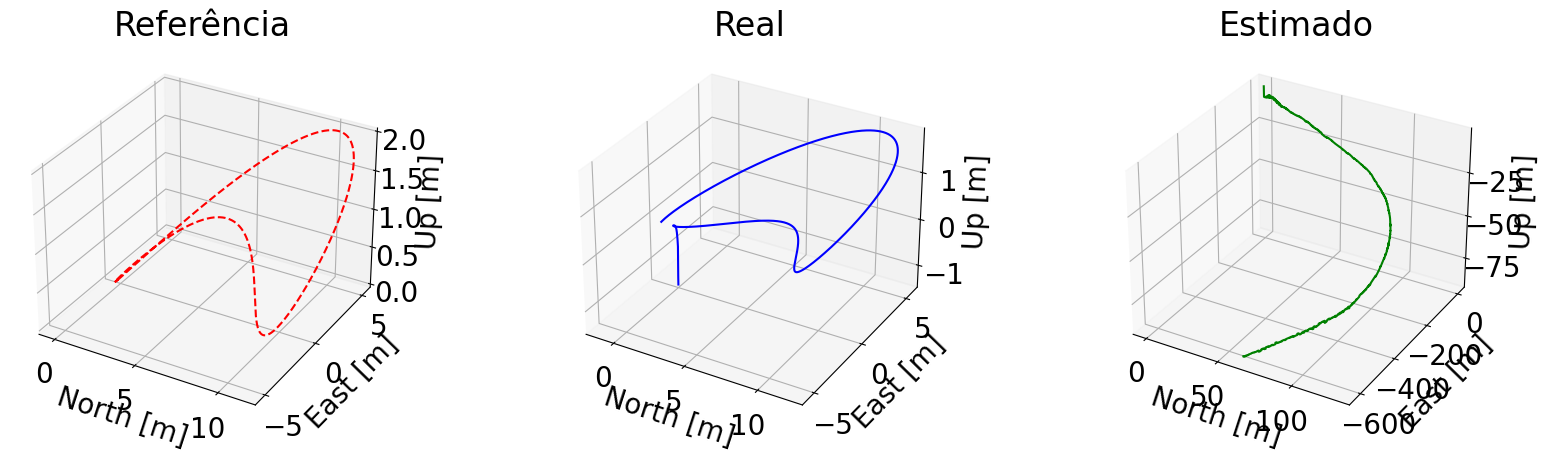

In [24]:
fig = plt.figure(figsize=(20,5))
ax11 = fig.add_subplot(1,3,1, title="Referência", projection='3d')
ax11.plot(np.array(histRefPos)[:, 0], np.array(histRefPos)[:, 1], np.array(histRefPos)[:, 2], '--r')
ax11.set_xlabel('North [m]')
ax11.set_ylabel('East [m]')
ax11.set_zlabel('Up [m]')

ax12 = fig.add_subplot(1,3,2, title="Real", projection='3d')
ax12.plot(np.array(histRealPos)[:, 0], np.array(histRealPos)[:, 1], np.array(histRealPos)[:, 2], 'b')
ax12.set_xlabel('North [m]')
ax12.set_ylabel('East [m]')
ax12.set_zlabel('Up [m]')

ax13 = fig.add_subplot(1,3,3, title="Estimado", projection='3d')
ax13.plot(np.array(histPos)[:, 0], np.array(histPos)[:, 1], np.array(histPos)[:, 2], 'g')
ax13.set_xlabel('North [m]')
ax13.set_ylabel('East [m]')
ax13.set_zlabel('Up [m]')

## ***Biases***

(-9.878749491256485, 9.878749491256485)

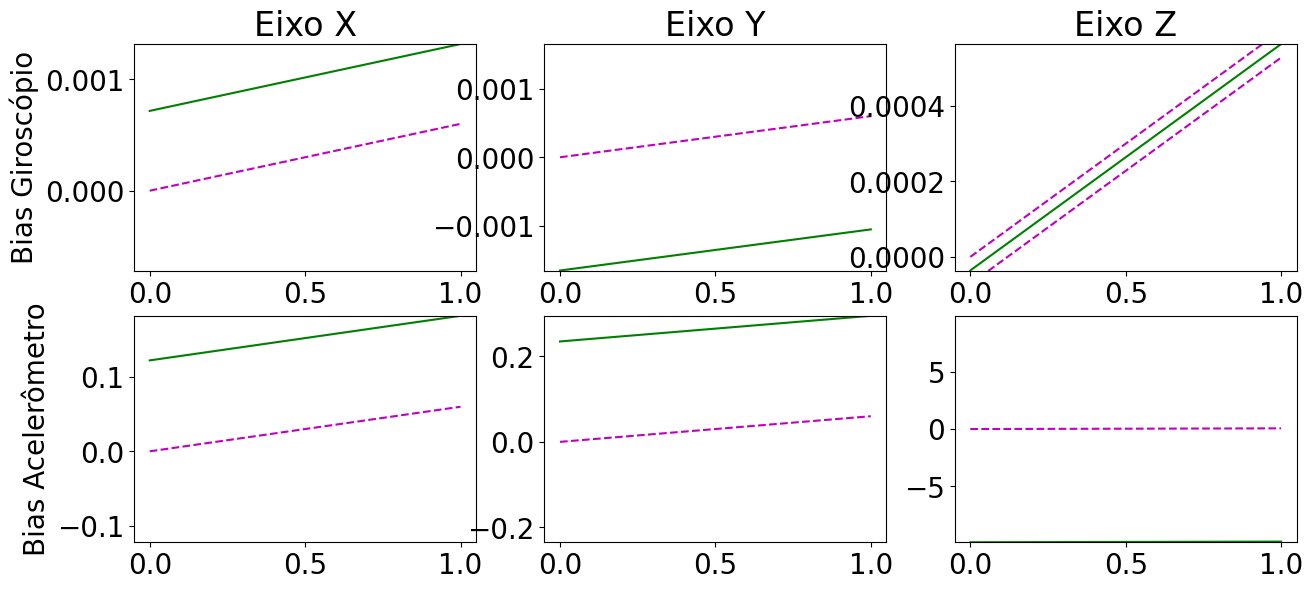

In [25]:
fig = plt.figure(figsize=(15,10))

''' Bias Giroscópio '''
ax11 = fig.add_subplot(3,3,1, title="Eixo X", ylabel="Bias Giroscópio")
ax11.plot(histTempo, np.array(histBias)[:,0], 'g')
ax11.plot(histTempo, np.array(histBias)[:,0] +np.array(histP)[:,9], '--m')
ax11.plot(histTempo, np.array(histBias)[:,0] -np.array(histP)[:,9], '--m')
ax11.set_ylim([np.min([np.min(np.array(histBias)[:,0]), 
                       -np.quantile(np.array(histP)[:,9], .25)]), 
               np.max([np.max(np.array(histBias)[:,0]), 
                       +np.quantile(np.array(histP)[:,9], .25)])])
ax12 = fig.add_subplot(3,3,2, title="Eixo Y")
ax12.plot(histTempo, np.array(histBias)[:,1], 'g')
ax12.plot(histTempo, np.array(histBias)[:,1] +np.array(histP)[:,10], '--m')
ax12.plot(histTempo, np.array(histBias)[:,1] -np.array(histP)[:,10], '--m')
ax12.set_ylim([np.min([np.min(np.array(histBias)[:,1]), 
                       -np.quantile(np.array(histP)[:,10], .25)]), 
               np.max([np.max(np.array(histBias)[:,1]), 
                       +np.quantile(np.array(histP)[:,10], .25)])])
ax13 = fig.add_subplot(3,3,3, title="Eixo Z")
ax13.plot(histTempo, np.array(histBias)[:,2], 'g')
ax13.plot(histTempo, np.array(histBias)[:,2] +np.array(histP)[:,11], '--m')
ax13.plot(histTempo, np.array(histBias)[:,2] -np.array(histP)[:,11], '--m')
ax13.set_ylim([np.min([np.min(np.array(histBias)[:,2]), 
                       -np.quantile(np.array(histP)[:,11], .25)]), 
               np.max([np.max(np.array(histBias)[:,2]), 
                       +np.quantile(np.array(histP)[:,11], .25)])])

''' Bias Acelerômetro '''
ax21 = fig.add_subplot(3,3,4, ylabel="Bias Acelerômetro")
ax21.plot(histTempo, np.array(histBias)[:,3], 'g')
ax21.plot(histTempo, np.array(histBias)[:,3] +np.array(histP)[:,12], '--m')
ax21.plot(histTempo, np.array(histBias)[:,3] -np.array(histP)[:,12], '--m')
ax21.set_ylim([np.min([np.min(np.array(histBias)[:,3]), 
                       -np.quantile(np.array(histP)[:,12], .25)]), 
               np.max([np.max(np.array(histBias)[:,3]), 
                       +np.quantile(np.array(histP)[:,12], .25)])])
ax22 = fig.add_subplot(3,3,5)
ax22.plot(histTempo, np.array(histBias)[:,4], 'g')
ax22.plot(histTempo, np.array(histBias)[:,4] +np.array(histP)[:,13], '--m')
ax22.plot(histTempo, np.array(histBias)[:,4] -np.array(histP)[:,13], '--m')
ax22.set_ylim([np.min([np.min(np.array(histBias)[:,4]), 
                       -np.quantile(np.array(histP)[:,13], .25)]), 
               np.max([np.max(np.array(histBias)[:,4]), 
                       +np.quantile(np.array(histP)[:,13], .25)])])
ax23 = fig.add_subplot(3,3,6)
ax23.plot(histTempo, np.array(histBias)[:,5], 'g')
ax23.plot(histTempo, np.array(histBias)[:,5] +np.array(histP)[:,14], '--m')
ax23.plot(histTempo, np.array(histBias)[:,5] -np.array(histP)[:,14], '--m')
ax23.set_ylim([np.min([np.min(np.array(histBias)[:,5]), 
                       -np.quantile(np.array(histP)[:,14], .25)]), 
               np.max([np.max(np.array(histBias)[:,5]), 
                       +np.quantile(np.array(histP)[:,14], .25)])])

# Arquivo .CSV

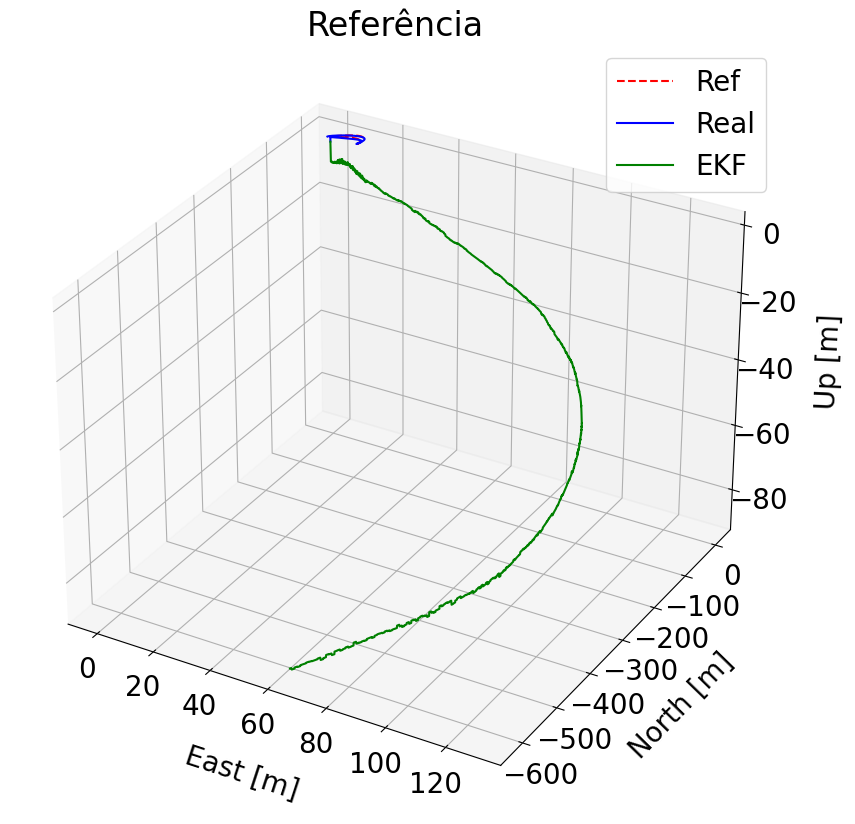

In [26]:
path = "Log Coppelia/Log_" +str(file_number) +".csv"
header = "timestamp,\
acc_x_real,acc_y_real,acc_z_real,acc_x,acc_y,acc_z,\
ang_vel_x_real,ang_vel_y_real,ang_vel_z_real,ang_vel_x,ang_vel_y,ang_vel_z,\
mag_x_real,mag_y_real,mag_z_real,mag_x,mag_y,mag_z,\
pos_n,pos_e,pos_d,pos_n_est,pos_e_est,pos_d_est,\
yaw,pitch,roll,yaw_est,pitch_est,roll_est"

n_dado = len(histTempo)
data_csv = np.hstack((np.array(histTempo).reshape(n_dado,1),
                      np.array(histRealAcc).reshape(n_dado,3),
                      np.array(histAcc).reshape(n_dado,3),
                      np.array(histRealGyro).reshape(n_dado,3),
                      np.array(histGyro).reshape(n_dado,3),
                      np.array(histRealMag).reshape(n_dado,3),
                      np.array(histMag).reshape(n_dado,3),
                      np.array(histRealPos).reshape(n_dado,3),
                      np.array(histPos).reshape(n_dado,3),
                      np.array(histRealAng).reshape(n_dado,3),
                      np.array(histAng).reshape(n_dado,3),
                     ))

np.savetxt(path, data_csv, delimiter=',', header=header)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, title="Referência", projection='3d')
ax.plot(np.array(histRefPos)[1:, 0], np.array(histRefPos)[1:, 1], np.array(histRefPos)[1:, 2], '--r')
ax.plot(np.array(histRealPos)[1:, 0], np.array(histRealPos)[1:, 1], np.array(histRealPos)[1:, 2], 'b')
ax.plot(np.array(histPos)[1:, 0], np.array(histPos)[1:, 1], np.array(histPos)[1:, 2], 'g')
ax.legend(["Ref", "Real", "EKF"])
ax.set_xlabel('East [m]', labelpad=20)
ax.set_ylabel('North [m]', labelpad=20)
ax.set_zlabel('Up [m]', labelpad=20)

plt.savefig(path_Folder +"/Log_" +str(file_number) +".pdf", bbox_inches='tight')

In [27]:
path_Folder +"/Log_" +str(file_number) 

'Log Coppelia/Log_12'